<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Project/Project02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

This notebook contains the first project assignment. You work on the project in groups. You should already have formed a group. If not, do it on Brightspace under *My Courses > Groups*. To get started, do the following steps:

1) One student in the group makes a copy of this notebook.
2) Share it with your group using *Share* top-right. Here, add group members under people with access.
3) Moreover, under *Share > General access*, choose *Anyone with the link > Commenter*. Copy this link and paste it below.
4) Work with the notebook and solve the tasks.
5) Hand in the notebook by downloading it: File > Download > Download .ipynb. Next, on BS under *Project*, upload the file (I need that for the exam). Moreover, add the shared link of your Colab notebook as a link when you handin too.
6) After hand-in do peer grading (see BS under *Project*)

Sharing link: https://colab.research.google.com/drive/1g6w82hfhlL_Kv6VJaMZY2IiGUPNsndyl?usp=sharing

**Deadlines**

* Hand-in solution 9/11/25
* Peer grading 15/11/25


# Notebook pre steps

In [ ]:
#@title Installations

# install missing packages
# !pip install pymdptoolbox
!pip install -q dfply
import numpy as np
from pprint import pprint
import pandas as pd
from plotnine import *
import joblib
import gzip
import gdown
import warnings
from scipy.stats import norm
from dfply import *
import itertools
from IPython.display import Markdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 8.7 MB/s eta 0:00:00


# Problem description

Consider the [Hour-to-hour electricity market problem](https://colab.research.google.com/drive/1BFI6iRLTnrHgxgFayC89SKhuM3XcIp7s?usp=sharing) that we solved using a Markov decision process by discretising the state and action space.

Here, we are going to solve the problem using model-free RL.

# Discretisation class

All methods for discretisation have been added to a class, that can be used to discretise the state and action space.


In [ ]:
#@title Discretisation class

class Discretise:
    """
    Methods for discretising continuous variables.

    Intervals are assumed to be of type [a,b[
    """

    def generate_discrete_set(self, min_val, max_val, step):
        """
        Generates a set of discrete values from min_val to max_val with step size.

        Args:
            min_val (float): The minimum value in the set.
            max_val (float): The maximum value in the set.
            step (float): The step size between consecutive values.

        Returns:
            set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
        """
        # Ensure step is a divisor of min_val
        if not np.isclose(min_val % step, 0):
            raise ValueError("min_val argument must be divisible by step.")
        if not np.isclose(max_val % step, 0):
            raise ValueError("max_val argument must be divisible by step.")
        return np.arange(min_val, max_val + step, step)


    def generate_intervals(self, min_val, max_val, length, add_inf = False, add_neg_inf = False):
        """
        Splits a given interval into n evenly spaced subintervals of type ]a,b] and returns midpoints and their corresponding bounds.

        Args:
            min_val (float): The minimum bound value of the first interval.
            max_val (float): The maximum bound value of the last interval.
            length (float): The interval length.
            add_inf (bool): Add infinity interval too (midpoint is calculated based on the last interval).
            add_neg_inf (bool): Add negative infinity interval too (midpoint is calculated based on the first interval).

        Returns:
            dict: A dictionary containing:
                - midpoints (list): Sorted list of midpoints in the intervals.
                - intervals_dict (dict): Mapping of midpoints to a dictionary containing 'ab' (bounds) and 'length'.
                - lower_inf (bool): Indicates if a negative infinity interval was added.
                - upper_inf (bool): Indicates if an infinity interval was added.
        """
        if not np.isclose((max_val - min_val) % length, 0):
            raise ValueError("(max_val - min_val) must be divisible by length.")

        bounds = np.arange(min_val, max_val + length, length)
        midpoints = np.arange(min_val + length/2, max_val + length/2, length)
        midpoints = midpoints.tolist()
        bounds = bounds.tolist()

        intervals_dict = {}
        for i in range(len(midpoints)):
            intervals_dict[midpoints[i]] = {'ab': [bounds[i], bounds[i+1]], 'length': length}

        if add_neg_inf:
            neg_inf_midpoint = bounds[0] - 1  # Calculate midpoint for the negative infinity interval
            intervals_dict[neg_inf_midpoint] = {'ab': [-np.inf, bounds[0]], 'length': np.inf}
            midpoints.insert(0, neg_inf_midpoint)

        if add_inf:
            inf_midpoint = bounds[-1] + 1  # Calculate midpoint for the infinity interval
            intervals_dict[inf_midpoint] = {'ab': [bounds[-1], np.inf], 'length': np.inf}
            midpoints.append(inf_midpoint)

        return {"midpoints": midpoints, 'intervals_dict': intervals_dict, "lower_inf": add_neg_inf, "upper_inf": add_inf}


    def get_interval(self, point, intervals, as_string = False):
        """
        Return interval bounds given a point and interval.

        Args:
            point (float): A point.
            intervals (dict): A dictionary
            as_string (bool): If true return the interval as a string.
        """
        midpoints = intervals['midpoints']
        intervals_dict = intervals['intervals_dict']
        lower_inf = intervals['lower_inf']
        upper_inf = intervals['upper_inf']

        # Check negative infinity interval
        if lower_inf and point < intervals_dict[midpoints[0]]['ab'][1]:
            if as_string:
                return str(intervals_dict[midpoints[0]]['ab'])
            else:
                return intervals_dict[midpoints[0]]['ab']

        # Check positive infinity interval
        if upper_inf and point >= intervals_dict[midpoints[-1]]['ab'][0]:
            if as_string:
                return str(intervals_dict[midpoints[-1]]['ab'])
            else:
                return intervals_dict[midpoints[-1]]['ab']

        # Check regular intervals
        for midpoint in midpoints:
            lower_bound, upper_bound = intervals_dict[midpoint]['ab']
            if lower_bound <= point < upper_bound:
                if as_string:
                    return str(intervals_dict[midpoint]['ab'])
                else:
                    return intervals_dict[midpoint]['ab']

        return None # Point is not in any defined interval


    def get_midpoint(self, point, intervals, interior = False):
        """
        Return interval midpoint given a point and intervals.

        Args:
            point (float): A point.
            intervals (dict): A dictionary
            interior (bool): If true only return the midpoint if the point is in the interior of an interval.
        """
        midpoints = intervals['midpoints']
        intervals_dict = intervals['intervals_dict']
        lower_inf = intervals['lower_inf']
        upper_inf = intervals['upper_inf']

        # Check negative infinity interval
        if lower_inf and point < intervals_dict[midpoints[0]]['ab'][1]:
            return midpoints[0]

        # Check positive infinity interval
        if not interior:
            if upper_inf and point >= intervals_dict[midpoints[-1]]['ab'][0]:
                return midpoints[-1]
        else:
            if upper_inf and point > intervals_dict[midpoints[-1]]['ab'][0]:
                return midpoints[-1]

        # Check regular intervals
        if not interior:
            for midpoint in midpoints:
                lower_bound, upper_bound = intervals_dict[midpoint]['ab']
                if lower_bound <= point < upper_bound:
                    return midpoint
        else:
            for midpoint in midpoints:
                lower_bound, upper_bound = intervals_dict[midpoint]['ab']
                if lower_bound < point < upper_bound:
                    return midpoint

        return None # Point is not in any defined interval


    def add_interval(self, a, b, intervals):
        """
        Add an interval to a list of intervals.
        This function assumes intervals sorted by midpoint.

        Args:
            a (float): The lower bound of the interval to add.
            b (float): The upper bound of the interval to add.
            intervals (dict): The existing dictionary of intervals.
        """
        if a >= b:
            raise ValueError("Lower bound must be smaller than upper bound.")
        if self.get_midpoint(a, intervals, interior = True) is not None or self.get_midpoint(b, intervals, interior = True) is not None:
            raise ValueError("Upper or lower bound is already in an interval.")
        for midpoint in intervals['midpoints']:
            if a <= midpoint <= b:
                raise ValueError("Upper or lower bound is already in an interval.")
        if a == np.inf:
            raise ValueError("Lower bound cannot be infinity.")
        if b == -np.inf:
            raise ValueError("Upper bound cannot be -infinity.")

        if a == -np.inf:
            intervals['lower_inf'] = True
            midpoint = b - 1
            length = np.inf
        if b == np.inf:
            intervals['upper_inf'] = True
            midpoint = a + 1
            length = np.inf
        if not a == -np.inf and not b == np.inf:
            midpoint = a + (b - a) / 2
            length = b - a
        new_interval_info = {'ab': [a, b], 'length': length}

        # Find the correct insertion point for the midpoint
        insert_index = 0
        for i, existing_midpoint in enumerate(intervals['midpoints']):
            if midpoint > existing_midpoint:
                insert_index = i + 1
            else:
                break

        intervals['midpoints'].insert(insert_index, midpoint)
        intervals['intervals_dict'][midpoint] = new_interval_info


    def remove_interval(self, point, intervals):
        """
        Remove an interval from the dictionary based on a point.

        Args:
            point (float): A point of the interval to remove.
            intervals (dict): The dictionary of intervals.

        Returns:
            bool: True if the interval was found and removed, False otherwise.
        """
        midpoint = self.get_midpoint(point, intervals)
        if not midpoint:
            return False

        if intervals['intervals_dict'][midpoint]['ab'][0] == -np.inf:
            intervals['lower_inf'] = False
        if intervals['intervals_dict'][midpoint]['ab'][1] == np.inf:
            intervals['upper_inf'] = False

        # Remove from midpoints list
        intervals['midpoints'].remove(midpoint)

        # Remove from intervals_dict
        del intervals['intervals_dict'][midpoint]

        return True


    def join_intervals(self, a, b, intervals):
        """
        Join two intervals if they are adjacent.

        Args:
            a (float): The lower bound of the first interval.
            b (float): The upper bound of the second interval.
            intervals (dict): The dictionary of intervals.

        Returns:
            bool: True if the intervals were joined, False otherwise.
        """
        a = self.get_midpoint(a, intervals)
        b = self.get_midpoint(b, intervals)
        if not a or not b:
            raise ValueError("At least one of the points is not in an interval.")
        if a == b:
            raise ValueError("Points are in the same interval")
            return False
        if (a > b):
            a, b = b, a
        a_idx = intervals['midpoints'].index(a)
        b_idx = intervals['midpoints'].index(b)
        if (a_idx != b_idx - 1):
            return False
        a_ab = intervals['intervals_dict'][a]['ab']
        b_ab = intervals['intervals_dict'][b]['ab']
        new_ab = [a_ab[0], b_ab[1]]
        if a_ab[0] == -np.inf:
            new_midpoint = b_ab[1] - 1
            new_length = np.inf
        if b_ab[1] == np.inf:
            new_midpoint = a_ab[0] + 1
            new_length = np.inf
        if not a_ab[0] == -np.inf and not b_ab[1] == np.inf:
            new_length = b_ab[1] - a_ab[0]
            new_midpoint = a_ab[0] + new_length/2
        new_interval = {'ab': new_ab, 'length': new_length}
        intervals['intervals_dict'][new_midpoint] = new_interval
        del intervals['intervals_dict'][a]
        del intervals['intervals_dict'][b]
        intervals['midpoints'][a_idx] = new_midpoint
        intervals['midpoints'].remove(b)
        return True


    def get_closest(self, lst, a):
        """
        Given a number finds the closest number in a list (if ties choose the smallest).

        Args:
            lst (list): The list of numbers to search within.
            a (float or int): The target number to find the closest value to.

        Returns:
            float or int: The number from the list that is closest to a.
        """
        idx = min(range(len(lst)), key=lambda i: abs(lst[i]-a))
        return lst[idx]

    def get_left(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', finds the largest number 'b' in
        the list so b <= a

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            list: If 'a' is equal to a number in the list, returns a.
                If 'a' is less than the smallest number, returns right.
                If 'a' is greater than the largest number, returns left.
                If 'a' is between two numbers in the list, returns left or right depending on `return_left`.
        """
        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list)-1, -1, -1):
            if sorted_list[i] <= a:
                return sorted_list[i]
        return None

    def get_right(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', find the smallest number 'b' in
        the list so a <= b

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            list: If 'a' is equal to a number in the list, returns a.
                If 'a' is less than the smallest number, returns right.
                If 'a' is greater than the largest number, returns left.
                If 'a' is between two numbers in the list, returns left or right depending on `return_left`.
        """
        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list)):
            if sorted_list[i] >= a:
                return sorted_list[i]
        return None

    def get_left_and_right(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', finds the left and right numbers
        'b' and 'c' in the list such that b <= a <= c.

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            list: [b,c]
        """
        # Handle edge cases: a is less than the smallest or greater than the largest
        if a < sorted_list[0]:
            return [None, sorted_list[0]]
        if a > sorted_list[-1]:
            return [sorted_list[-1], None]

        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list) - 1):
            left = sorted_list[i]
            right = sorted_list[i+1]
            if left <= a <= right:
                return [left, right]

        # This part should ideally not be reached if edge cases are handled and the list is sorted
        return None

    def get_interval_midpoint(self, a, intervals):
        """
        Return interval midpoint given a point and interval.

        Args:
            midpoint (float): The midpoint of the interval.
            intervals (dict): A dictionary
        """
        midpoints = intervals['midpoints']
        intervals_dict = intervals['intervals_dict']
        for midpoint in midpoints:
            lower_bound, upper_bound = intervals_dict[midpoint]['ab']
            if lower_bound <= a < upper_bound:
                return midpoint
        return None



Run code

In [ ]:
dis = Discretise()
tmp = dis.generate_discrete_set(0, 10, 2)
n = 14
print(dis.get_left(tmp, n))
print(dis.get_right(tmp, n))

10
None


## Q1

Explain functions `get_left` and `get_right`.

- What is input?
- What is returned?
- What is the result if `n` is -1, 0 or 14?

In [ ]:
#@title Solution

# Your code
dis = Discretise()
tmp = dis.generate_discrete_set(0, 10, 2)
n = [-1, 0, 14]
for n in n:
    print(dis.get_left(tmp, n))
    print(dis.get_right(tmp, n))

display(Markdown("""
* Get left takes a list and a number as input, then returns the largest number in the list that is smaller than or equal to the input number.

* Get right takes a list and a number as input, then returns the smallest number in the list, that is larger than or equal to the input number.

* For -1:
  * Get left returns None as no number in the list is smaller than -1
  * Get right returns 0 as 0 is the smallest number in the list that is larger than or equal to -1

* For 0:
  * Get left returns 0 as 0 is equal to 0 in the list
  * Get right returns 0 again, as the input 0 is equal to zero in the list

* For 14:
  * Get left returns 10 as 10 is the largest number in the list that is smaller than or equal to 14
  * Get right returns None as no number in the list is larger than or equal to 14
"""))

None
0
0
0
10
None



* Get left takes a list and a number as input, then returns the largest number in the list that is smaller than or equal to the input number.

* Get right takes a list and a number as input, then returns the smallest number in the list, that is larger than or equal to the input number.

* For -1:
  * Get left returns None as no number in the list is smaller than -1
  * Get right returns 0 as 0 is the smallest number in the list that is larger than or equal to -1

* For 0:
  * Get left returns 0 as 0 is equal to 0 in the list
  * Get right returns 0 again, as the input 0 is equal to zero in the list

* For 14:
  * Get left returns 10 as 10 is the largest number in the list that is smaller than or equal to 14
  * Get right returns None as no number in the list is larger than or equal to 14


# Problem environment

To model the problem, we need to define an environment class:

In [ ]:
#@title EnvEnergy environment class

from scipy import integrate
import numpy as np
from scipy.stats import norm, lognorm
from scipy.optimize import root_scalar
import ast
import pandas as pd
import itertools

class EnvEnergy:
    """
    Environment for the hour-to-hour electricity market problem.
    """

    def __init__(self, settings, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)
        self.dis = Discretise()  # methods for discretisation

        # To store current state values for wind and price to use in get_time_step_data (since continuous and interval)
        self.s_p = None
        self.s_w = None

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def set_discretisation(self, s_l_set, s_c_set, s_w_inv, s_p_inv, a_b_set, a_w_set, a_c_set):
        """
        Set the discretisation.

        Args:
            s_l_set (list): A list of possible battery levels
            s_c_set (list): A list of possible commitment levels
            s_w_inv (dict): A dictionary containing the intervals for wind
            s_p_inv (dict): A dictionary containing the intervals for price
            a_b_set (list): A list of possible battery usage
            a_w_set (list): A list of possible wind usage
            a_c_set (list): A list of possible commitment levels
        """
        self.s_l_set = s_l_set
        self.s_c_set = s_c_set
        self.s_w_inv = s_w_inv
        self.s_p_inv = s_p_inv
        self.a_b_set = a_b_set
        self.a_w_set = a_w_set
        self.a_c_set = a_c_set

    def get_states(self):
        """
        Get all possible states.
        """
        return [self.state_variables_to_str(s_l, s_c, s_w, s_p) for s_l in self.s_l_set for s_c in self.s_c_set for s_w in self.s_w_inv['midpoints'] for s_p in self.s_p_inv['midpoints']]

    def get_actions(self, s: dict) -> list:
        """
        Get all possible actions for a given state.
        """
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.dis.get_left(self.a_w_set, self.energy(s['s_w'])) # max energy we can sell/produce (e.g. if energy(s['s_w']) = 1.25 but a_w_set is [0,1,2,...] then can only sell 1)
        if s['s_c'] >= 0:
            if s['s_c'] >= e_max:
                a_b = min(s['s_l'], s['s_c'] - e_max)
                a_w = e_max
            else: # s['s_c'] < e_max:
                a_b = -min(b_max - s['s_l'], e_max - s['s_c'])
                a_w = s['s_c'] - a_b
        else: # s['s_c'] < 0:
            a_b = -min(b_max - s['s_l'], - s['s_c'] + e_max)
            a_w = max(0, - a_b + s['s_c'])

        actions = [self.action_variables_to_str(a_b, a_w, a_c) for a_c in self.a_c_set]
        # actions = [str_to_dict(a) for a in actions]
        return actions

    def reset_current_state(self):
        """
        Reset the current price and wind speed to None. Hence, assume no previous
        state (we start our sample run).
        """
        self.s_p = None
        self.s_w = None

    def set_current_state(self, s):
        """
        Set the current price and wind speed given a state (dict)
        """
        self.s_p = s['s_p']
        self.s_w = s['s_w']

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def str_to_dict(self, str):
        """
        Convert a string representation of a dictionary to a dictionary.

        Args:
            str (str): String representation of a dictionary.

        Returns:
            dict: Converted dictionary.
        """
        return ast.literal_eval(str)

    def dict_to_str(self, d):
        """
        Convert a dictionary to a string representation of a dictionary.

        Args:
            d (dict): Dictionary to be converted.

        Returns:
            str: String representation of the dictionary.
        """
        return str(d)

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def energy_inverse(self, energy_target, time_period_length = 1):
        """
        Find the wind speed that produces a given amount of energy, assuming wind is between w_cut_in and w_rated.

        Args:
            energy_target (float): The target energy output in MWh.
            time_period_length (float, optional): The time period length in hours. Defaults to 1.

        Returns:
            float: The wind speed that produces the given energy.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']

        if energy_target < 0 or energy_target > p_max:
            return None

        def find_wind_speed(w):
            return self.energy(w, time_period_length) - energy_target

        sol = root_scalar(find_wind_speed, bracket=[w_cut_in, w_rated], method='brentq')
        return sol.root if sol.converged else None


    # def get_left_or_right(self, sorted_list, a, return_left = True):
    #     """
    #     Given a sorted list and a number 'a', finds the left and right numbers
    #     in the list that 'a' is between.
    #     """
    #     # Handle edge cases: a is less than the smallest or greater than the largest
    #     if a < sorted_list[0]:
    #         return sorted_list[0]
    #     if a > sorted_list[-1]:
    #         return sorted_list[-1]

    #     # Iterate through the sorted list to find the bounds
    #     for i in range(len(sorted_list) - 1):
    #         left = sorted_list[i]
    #         right = sorted_list[i+1]

    #         if left <= a <= right:
    #             # If a is exactly in the list or between two numbers
    #             if a == left or a == right:
    #                 return a
    #             elif return_left:
    #                 return left
    #             else:
    #                 return right

    #     # This part should ideally not be reached if edge cases are handled and the list is sorted
    #     return None

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        log_wind = np.log(wind)
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    # def get_interval_midpoint(self, a, intervals):
    #     """
    #     Return interval midpoint given a point and interval.

    #     Args:
    #         midpoint (float): The midpoint of the interval.
    #         intervals (dict): A dictionary
    #     """
    #     midpoints = intervals['midpoints']
    #     intervals_dict = intervals['intervals_dict']
    #     for midpoint in midpoints:
    #         lower_bound, upper_bound = intervals_dict[midpoint]['ab']
    #         if lower_bound <= a < upper_bound:
    #             return midpoint
    #     return None

    def get_time_step_data(self, s, a):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            Dict with:
                - 'r': float reward.
                - 'sN': next state label "xN,yN".
        """
        a = self.str_to_dict(a)
        a_b = a['a_b']
        a_w = a['a_w']
        a_c = a['a_c']
        s = self.str_to_dict(s)
        s_l = s['s_l']
        s_c = s['s_c']
        if not self.s_p: self.s_p = s['s_p']  # initialize if starting state
        if not self.s_w: self.s_w = s['s_w']

        # # check
        # s_w = s['s_w']
        # s_p = s['s_p']
        # if self.dis.get_interval_midpoint(self.s_p, self.s_p_inv) != s_p:
        #     print("Current price:", self.s_p)
        #     print("State midpoint:", s_p)
        #     print("State interval:", self.s_p_inv['intervals_dict'][s_p])
        #     raise ValueError("Invalid p state.")
        # if self.dis.get_interval_midpoint(self.s_w, self.s_w_inv) != s_w:
        #     print("Current wind:", self.s_w)
        #     print("State midpoint:", s_w)
        #     print("State interval:", self.s_w_inv['intervals_dict'][s_w])
        #     raise ValueError("Invalid w state.")

        s_p = self.s_p  # assume that current value of s_p is stored in self.s_p
        s_w = self.s_w
        # print("Current wind and price:", s_w, "|", s_p)

        s_l_next = s_l - a_b
        s_c_next = a_c
        self.s_w = self.generate_wind_next_hour(self.s_w) # update current values
        self.s_p = self.generate_price_next_hour(self.s_p)
        # print("New wind and price:", s_w, "|", s_p)
        s_p_next = self.dis.get_interval_midpoint(self.s_p, self.s_p_inv)
        s_w_next = self.dis.get_interval_midpoint(self.s_w, self.s_w_inv)
        s_next = self.state_variables_to_str(s_l_next, s_c_next, s_w_next, s_p_next)
        reward = self.get_reward(s_p, s_c, a_b, a_w)
        return {"r": reward, "sN": s_next}

## Q2

Explain what the method `get_time_step_data` does.

- What is input?
- What is the role of `self.s_p` and `self.s_w`?
- What is the purpose of the `generate_` methods?
- What is returned?

In [ ]:
#@title Solution
display(Markdown("""
* What is the input?
  * It takes the state and action label.

* What is the role of self.s_p and self.s_w?
  * The purpose of the two is that they define the state space we are in, they define price and wind.

* What is the purpose of the generate_ methods?
  * The purpose of that is to generate the values for the next state, here both the price and wind level based on a probability distribution

* What is returned?
  * It returns the reward and the next state.
"""))


* What is the input?
  * It takes the state and action label.

* What is the role of self.s_p and self.s_w?
  * The purpose of the two is that they define the state space we are in, they define price and wind.

* What is the purpose of the generate_ methods?
  * The purpose of that is to generate the values for the next state, here both the price and wind level based on a probability distribution

* What is returned?
  * It returns the reward and the next state.


# Create environment


We consider the following problem parameters and create the environment.

In [ ]:
#@title Problem parameters

settings = {
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}
env = EnvEnergy(settings)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


Note that the environment need a discretisation to work.

In [ ]:
#@title Discretisation used

## Discretisation parameters
step_mwh = 2  # step_mwh (float): Step size for energy resolution.

## Create discretisation
b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
w_cut_in = settings['w_cut_in']
w_rated = settings['w_rated']
w_cut_out = settings['w_cut_out']
dis = Discretise()

# Action variables
a_b_set = dis.generate_discrete_set(-b_max, b_max, step_mwh)
a_w_set = dis.generate_discrete_set(0, p_max, step_mwh)
a_c_set = dis.generate_discrete_set(-b_max, c_max, step_mwh)
print("Battery usage a_b:", a_b_set)
print("Wind usage a_w:", a_w_set)
print("Commitment t+1 a_c:", a_c_set)

# Battery (MWh)
s_l_set = dis.generate_discrete_set(0, b_max, step_mwh)
print("Battery level s_l:", s_l_set)

# Commitment (MWh)
s_c_set = dis.generate_discrete_set(-b_max, c_max, step_mwh)
print("Commitment s_c:", s_c_set)

# Wind (m/s)
val = [round(env.energy_inverse(e), 1) for e in a_w_set]  # wind speeds corresponding to a_w_set
print("\nWind speeds corresponding to a_w_set:", val)   # want these as midpoints in intervals
s_w_inv = dis.generate_intervals(0, val[1], val[1])    # zero commitment
for i, v in enumerate(val):
    if i > 1:
        dis.add_interval(val[i-1], v, s_w_inv)
dis.add_interval(w_rated, w_cut_out, s_w_inv)
dis.add_interval(w_cut_out, np.inf, s_w_inv)
e_prod = [env.energy(w) for w in s_w_inv['midpoints']] # possible energy production given wind intervals
print("Possible energy production given wind intervals:", e_prod)
print("What we can sell given intervals:", [env.dis.get_left(a_w_set, e) for e in e_prod])  # what we can sell
print("Wind s_w:")
pprint(s_w_inv)

# Prices (Euro)
s_p_inv = dis.generate_intervals(-40, 15, 5, add_inf = True, add_neg_inf = True)
print("\nPrices s_p:")
pprint(s_p_inv)

env.set_discretisation(s_l_set, s_c_set, s_w_inv, s_p_inv, a_b_set, a_w_set, a_c_set)

Battery usage a_b: [-10  -8  -6  -4  -2   0   2   4   6   8  10]
Wind usage a_w: [ 0  2  4  6  8 10]
Commitment t+1 a_c: [-10  -8  -6  -4  -2   0   2   4   6   8  10  12  14  16  18  20]
Battery level s_l: [ 0  2  4  6  8 10]
Commitment s_c: [-10  -8  -6  -4  -2   0   2   4   6   8  10  12  14  16  18  20]

Wind speeds corresponding to a_w_set: [3.0, 8.3, 9.6, 10.6, 11.4, 12.0]
Possible energy production given wind intervals: [0.02086248285322362, 2.889504458161864, 4.909615912208504, 7.023319615912207, 9.03296296296296, 10, 0]
What we can sell given intervals: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(0)]
Wind s_w:
{'intervals_dict': {4.15: {'ab': [0.0, 8.3], 'length': 8.3},
                    8.95: {'ab': [8.3, 9.6], 'length': 1.299999999999999},
                    10.1: {'ab': [9.6, 10.6], 'length': 1.0},
                    11.0: {'ab': [10.6, 11.4], 'length': 0.8000000000000007},
                    11.7: {'ab': [11.4, 12.0], 'lengt

## Q3

Explain the output.

- What levels of energy can be sold/bought?
- Why are these specific wind intervals used?
- Why are price intervals small around zero?
- How is the discretisation added to the environment?  

In [ ]:
#@title Solution

display(Markdown("""
* What levels of energy can be sold/bought?
  * The energy level step size is 2, and it is possible to sell up to 20 MW, and buy 10 MW, as we can sell 10 MW from the battery and 10 MW from the windmill, and buy a total fo 10MW to the battery. The list of possibilities can be seen in the output
  * [-10  -8  -6  -4  -2   0   2   4   6   8  10  12  14  16  18  20]

* Why are these specific wind intervals used?
  * These wind intervals are used to specify the intervals for which the windmill produced an extra 2 MW, which is the step size.

* Why are price intervals small around zero?
  * The price intervals around 0 are chosen as these are the most intersting prices to focus on in the analysis, as the it is often always best to sell when prices are too high, but around 0 there are more variation.

* How is the discretisation added to the environment?
  * Discretisation is added to the envrionment by the set_discretisation function, which adds all the specified intervals to the environment.
"""))


* What levels of energy can be sold/bought?
  * The energy level step size is 2, and it is possible to sell up to 20 MW, and buy 10 MW, as we can sell 10 MW from the battery and 10 MW from the windmill, and buy a total fo 10MW to the battery. The list of possibilities can be seen in the output
  * [-10  -8  -6  -4  -2   0   2   4   6   8  10  12  14  16  18  20]

* Why are these specific wind intervals used?
  * These wind intervals are used to specify the intervals for which the windmill produced an extra 2 MW, which is the step size.

* Why are price intervals small around zero?
  * The price intervals around 0 are chosen as these are the most intersting prices to focus on in the analysis, as the it is often always best to sell when prices are too high, but around 0 there are more variation.

* How is the discretisation added to the environment?
  * Discretisation is added to the envrionment by the set_discretisation function, which adds all the specified intervals to the environment.


Let us test the environment:

In [ ]:
print("price:")
pprint(s_p_inv)
print("wind:")
pprint(s_w_inv)
print()
states = env.get_states()
s = states[2300]
actions = env.get_actions(env.str_to_dict(s))
a = env.dict_to_str(np.random.choice(actions))
env.reset_current_state()
for i in range(5):
    print("State:", s)
    print("Action:", a)
    res = env.get_time_step_data(s, a)
    print("Reward and new state:", res)
    print("Current price (in the inverval):", env.s_p)
    print("Current wind (in the inverval):", env.s_w, "\n")
    s = res['sN']
    a = env.dict_to_str(np.random.choice(env.get_actions(env.str_to_dict(s))))

price:
{'intervals_dict': {-41: {'ab': [-inf, -40], 'length': inf},
                    -37.5: {'ab': [-40, -35], 'length': 5},
                    -32.5: {'ab': [-35, -30], 'length': 5},
                    -27.5: {'ab': [-30, -25], 'length': 5},
                    -22.5: {'ab': [-25, -20], 'length': 5},
                    -17.5: {'ab': [-20, -15], 'length': 5},
                    -12.5: {'ab': [-15, -10], 'length': 5},
                    -7.5: {'ab': [-10, -5], 'length': 5},
                    -2.5: {'ab': [-5, 0], 'length': 5},
                    2.5: {'ab': [0, 5], 'length': 5},
                    7.5: {'ab': [5, 10], 'length': 5},
                    12.5: {'ab': [10, 15], 'length': 5},
                    16: {'ab': [15, inf], 'length': inf}},
 'lower_inf': True,
 'midpoints': [-41,
               -37.5,
               -32.5,
               -27.5,
               -22.5,
               -17.5,
               -12.5,
               -7.5,
               -2.5,
               2.5,

## Q4

Explain the output.

- Why is calling `env.reset_current_state()` important when start exploring?
- Which policy is used here to select actions?
- Check that the current price is in the interval of the new state.
- How is the reward calculated? That is, which variables are used, and how do these relate to the discretisation?




In [ ]:
#@title Solution

display(Markdown("""

* Why is calling env.reset_current_state() important when start exploring?
  * We want to reset s_p and s_w, because they store values continuously. So when exploring we start from a clean slate.

* Which policy is used here to select actions?
  * np.random.choice = generates a random sample from the array

* Check that the current price is in the interval of the new state.
  * Current price for each state: 24.33, 28.67, 32.93, 38.14 and 47.73.
  * All of the prices are in the interval 15:inf, which is the price interval for their given state (s_p = 16)

* How is the reward calculated? That is, which variables are used, and how do these relate to the discretisation?
  * See the get_reward function from the environment class.
  * Reward calculated as = s_c * s_p - c_plus * abs(s_c - e)
  * So: revenue from commitment * price - imbalance cost (penalty from not meeting commitment)


"""))



* Why is calling env.reset_current_state() important when start exploring?
  * We want to reset s_p and s_w, because they store values continuously. So when exploring we start from a clean slate.

* Which policy is used here to select actions?
  * np.random.choice = generates a random sample from the array

* Check that the current price is in the interval of the new state.
  * Current price for each state: 24.33, 28.67, 32.93, 38.14 and 47.73.
  * All of the prices are in the interval 15:inf, which is the price interval for their given state (s_p = 16)

* How is the reward calculated? That is, which variables are used, and how do these relate to the discretisation?
  * See the get_reward function from the environment class.
  * Reward calculated as = s_c * s_p - c_plus * abs(s_c - e)
  * So: revenue from commitment * price - imbalance cost (penalty from not meeting commitment)




# MDP solution

Before solving the problem using model-free RL. Let us consider the optimal policy given a discount rate of 0.5, found using the MDP and policy iteration.

In [ ]:
df_mdp_05 = pd.read_csv('https://drive.google.com/uc?id=1-hkOOFmtQ4bBWA4h81r0UGU26fRop6n8', index_col = False)
df_mdp_05 >> head(2)

,state,action,pr,v,s_l,s_c,s_w,s_p,a_b,a_w,...,e,imbalance,E,reward,s_w_idx,s_w_str,s_p_idx,s_p_str,s_idx,steady_pr
0,"{'s_l': 0, 's_c': -10, 's_w': 4.15, 's_p': -41}","{'a_b': -10, 'a_w': 0, 'a_c': 0}",1,572.051593,0.0,-10.0,4.15,-41.0,-10,0,...,-10,False,0.020862,500.0,0,"[0.0, 8.3]",0,"[-inf, -40]",0,0.000912
1,"{'s_l': 0, 's_c': -10, 's_w': 4.15, 's_p': -37.5}","{'a_b': -10, 'a_w': 0, 'a_c': 0}",1,505.635966,0.0,-10.0,4.15,-37.5,-10,0,...,-10,False,0.020862,375.0,0,"[0.0, 8.3]",1,"[-40, -35]",1,0.000324


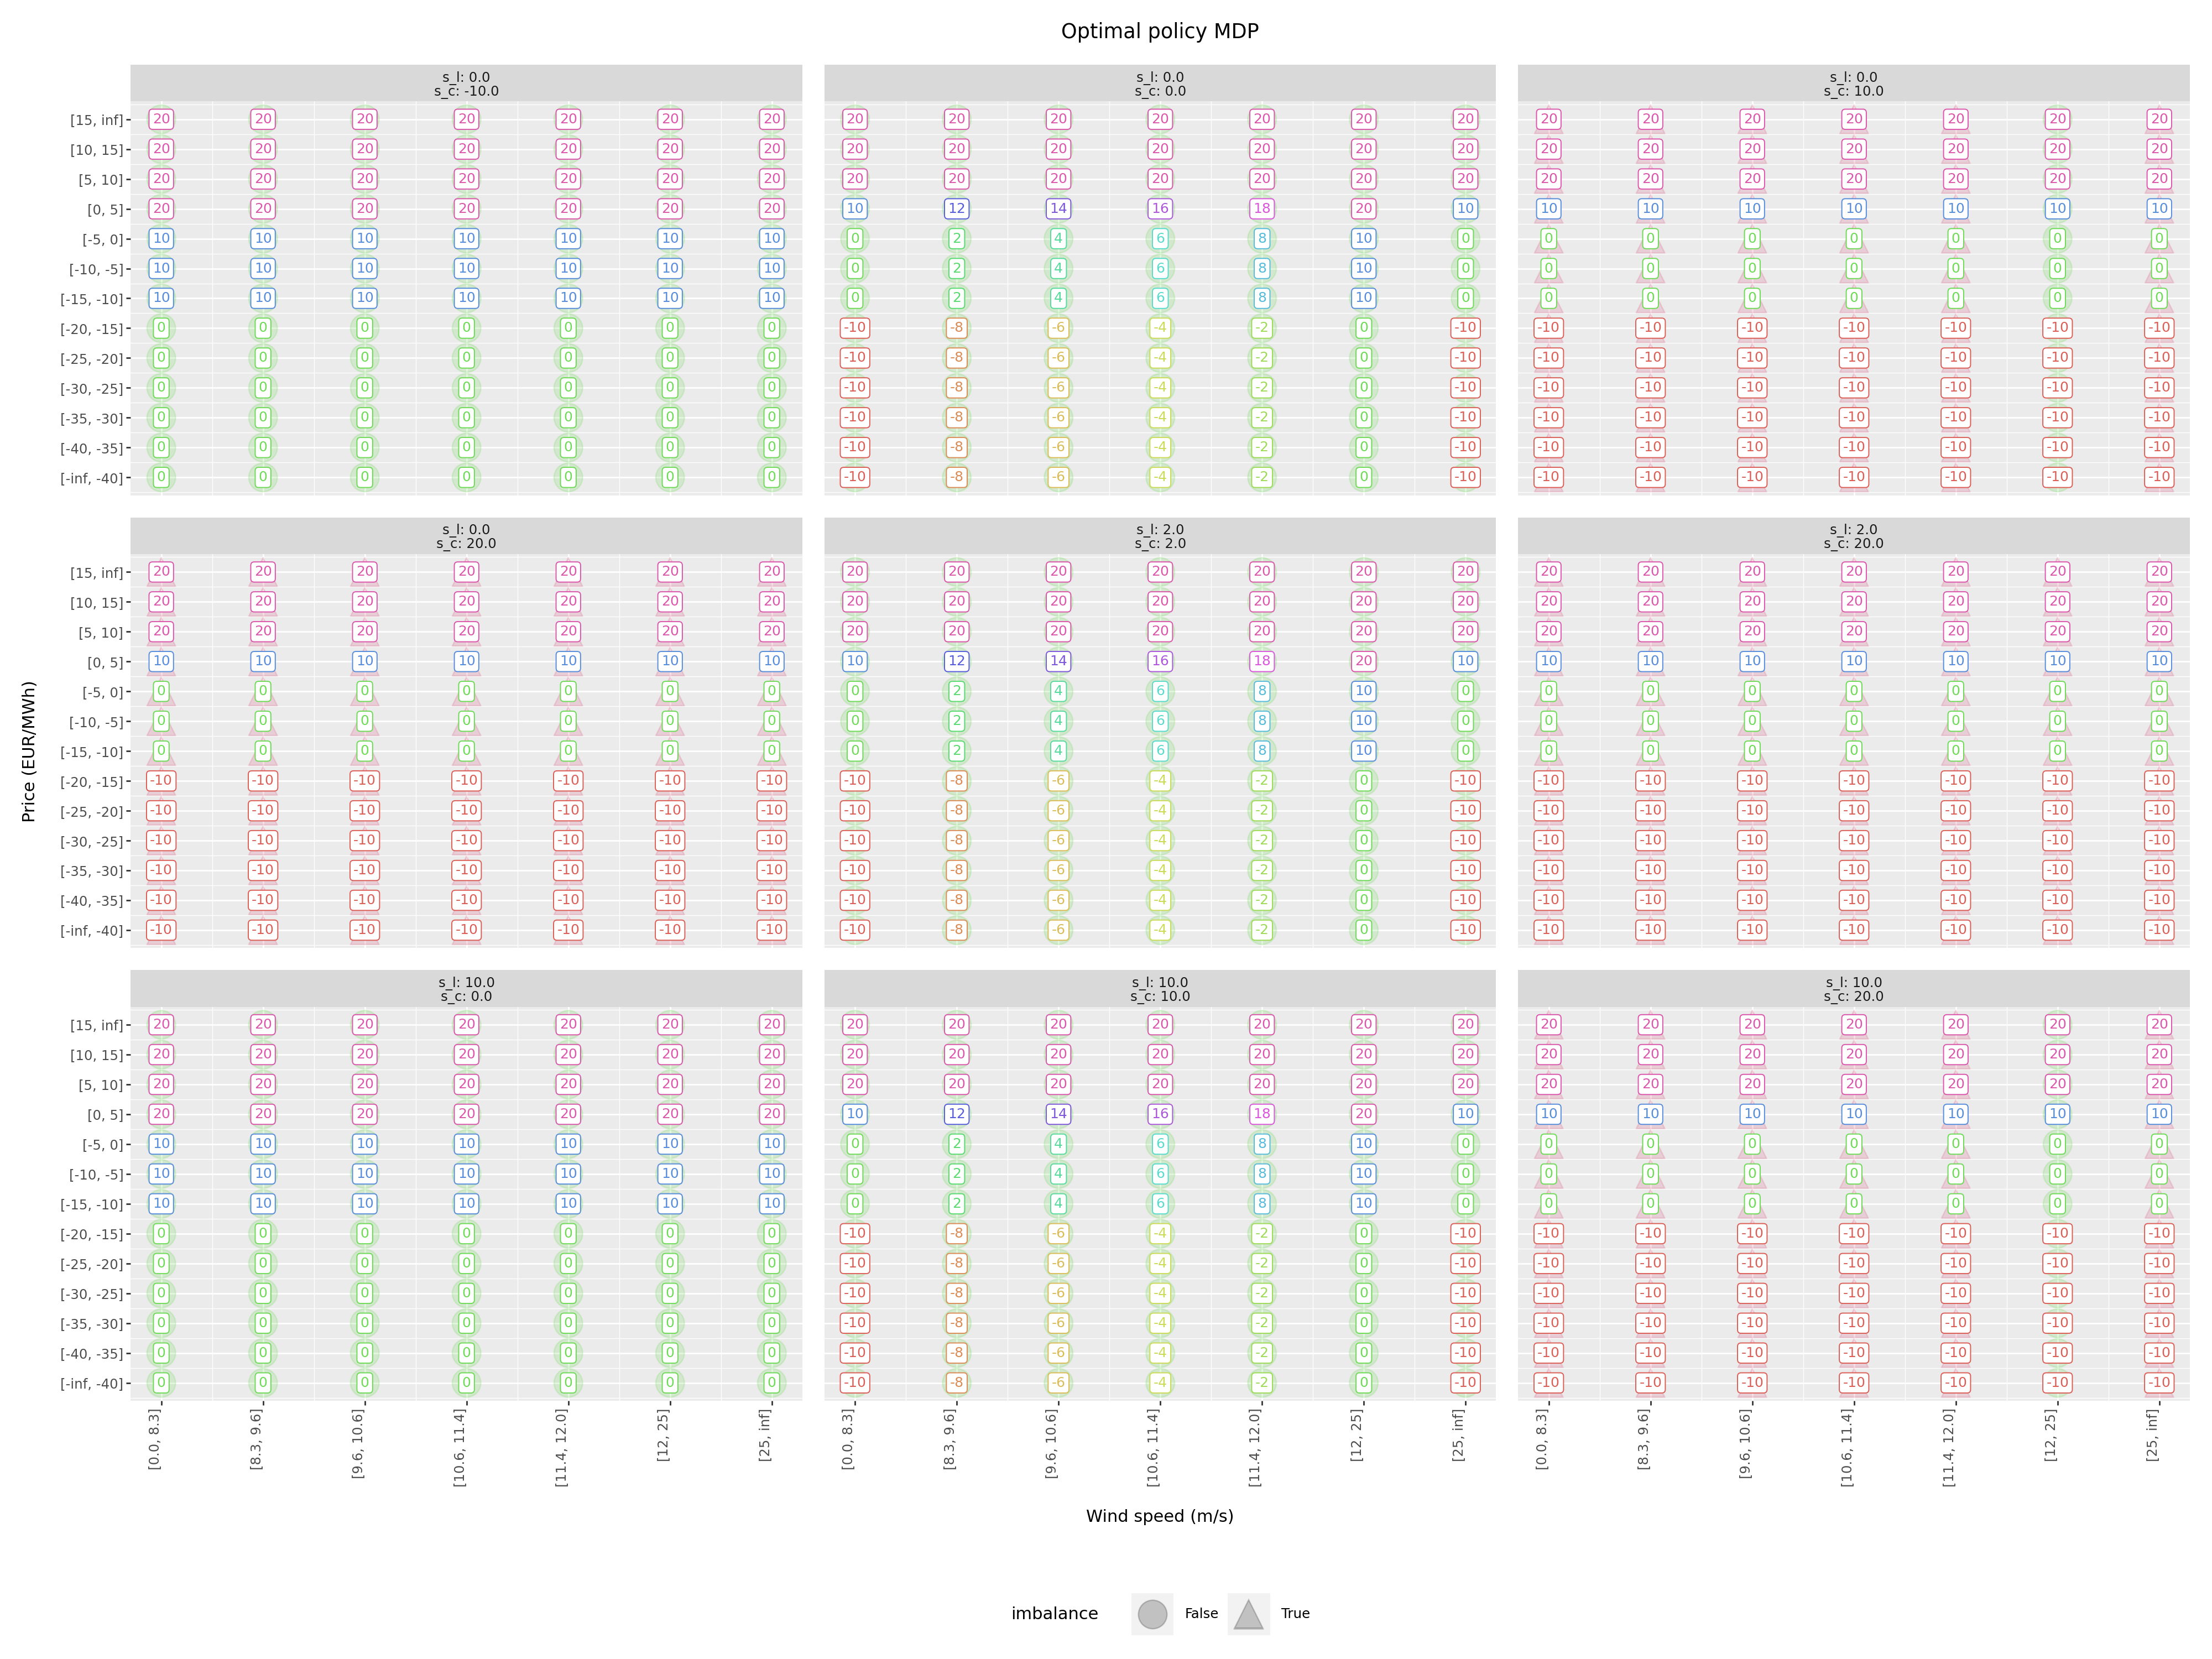

In [ ]:
## Plot some results
dat = (
    df_mdp_05
        >> mask((X.s_l == 0) | (X.s_l == 2) | (X.s_l == 5) | (X.s_l == 10))
        >> mask((X.s_c == -10) | (X.s_c == -2) | (X.s_c == 0) | (X.s_c == 2) | (X.s_c == 10) | (X.s_c == 20))
        >> mask(X.steady_pr > 0)
)
dat['a_c'] = pd.Categorical(dat['a_c'])  # Convert 'a_c' to a categorical variable for discrete scaling
pt = (
    ggplot(dat, aes("s_w_idx", "s_p_idx", label = "a_c", color="a_c"))
    + geom_point(aes(shape = 'imbalance', color='imbalance'), size = 10, alpha = 0.2)
    + geom_label(size = 9)
    + facet_wrap("~ s_l + s_c", labeller="label_both")
    # + facet_grid(rows = "s_l", cols = "s_c", labeller="label_both")
    # + theme(legend_position='none')
    + labs(title = f"Optimal policy MDP", x = "Wind speed (m/s)", y = "Price (EUR/MWh)")
    + theme(figure_size=(20,15), axis_text_x=element_text(rotation=90, hjust=1), legend_position="bottom")
    # + guides(color=guide_legend(nrow=2, byrow=True))
    + guides(color=False)
    + scale_color_discrete()
    + scale_x_continuous(breaks=dat['s_w_idx'].unique(), labels=dat['s_w_str'].unique())
    + scale_y_continuous(breaks=dat['s_p_idx'].unique(), labels=dat['s_p_str'].unique())
)
pt.show()

Let us calculate the min, average and max state-value.

In [ ]:
df_mdp_05 >> summarise(min_v = X.v.min(), avg_v = X.v.mean(), max_v = X.v.max())

,min_v,avg_v,max_v
0,-1727.372198,343.224768,4454.201269


# Create agent  

We are now ready to create the agent and do model-free RL. First, we load the agent class.

In [ ]:
#@title Generic RL agent

import math  # math helpers
import random  # tie-breaking choices
from collections import defaultdict  # lazy nested dicts
from typing import Optional, List, Dict, Any  # typing

import numpy as np  # vector ops and RNG
import pandas as pd  # tabular data


try:
    from plotnine import ggplot, aes, geom_col, geom_tile, labs, theme_minimal  # plotting
except Exception:  # pragma: no cover
    ggplot = None  # fallback if plotnine isn't installed


class RLAgent:
    """
    Tabular RL agent with:
      - per-state action dictionaries {'q': value, 'n': visits}
      - behavior policy pi (dict action->prob)
      - state value v and state visit counter n

    Uses defaultdict so states/actions can be created lazily.
    """

    def __init__(self) -> None:
        # model[state] = dict with keys:
        #   'pi': policy dict(action->prob)
        #   'v': state value
        #   'n': state visit count
        #   'actions': dict(action -> {'q': float, 'n': int})
        self.model: Dict[str, Dict[str, Any]] = defaultdict(
            lambda: {
                "pi": None,     # policy probabilities
                "v": float("nan"),  # state value
                "n": 0,         # state visits
                "actions": defaultdict(lambda: {"q": 0.0, "n": 0}),  # actions
            }
        )  # core store

    # ----------------------------- helpers ------------------------------------

    def add_states(self, states: List[str]) -> None:
        """Force creation of states (defaultdict makes them auto-create)."""  # eager create
        for s in states:
            _ = self.model[str(s)]  # touch to ensure creation

    def add_state_action(self, s: str, a: str) -> None:
        """Ensure a state and a specific action exist."""  # lazy create
        _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_actions(self, s: str, actions: List[str]) -> None:
        """Force creation of actions in state s."""  # batch add
        for a in actions:
            _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_states_and_actions(self, df: pd.DataFrame) -> None:
        """Bulk add (state, action) pairs from DataFrame with columns 's' and 'a'."""  # bulk
        for s, a in zip(df["s"].astype(str), df["a"].astype(str)):
            _ = self.model[s]["actions"][a]  # touch-create

    # ----------------------------- setters ------------------------------------

    def set_action_value(self, value: float = 0.0) -> None:
        """Set q(s,a) to constant for all actions."""  # initializer/reset
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["q"] = float(value)  # assign

    def set_state_value(self,
                        states: Optional[List[str]] = None,
                        value: float = 0.0) -> None:
        """Set v(s) for given states (all if None)."""  # V setter
        states = states or list(self.model.keys())
        for s in states:
            self.model[s]["v"] = float(value)  # assign

    def set_action_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all action counters to ctr_value."""  # reset N(s,a)
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["n"] = int(ctr_value)  # assign

    def set_state_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all state visit counters to ctr_value."""  # reset N(s)
        for s in self.model:
            self.model[s]["n"] = int(ctr_value)  # assign

    def set_action_value_single(self,
                                s: str,
                                a: str,
                                value: float = 0.0,
                                ctr_value: int = 0) -> None:
        """Set q(s,a) and n(s,a) for a single state-action."""  # direct set
        _ = self.model[str(s)]["actions"][str(a)]  # ensure exists
        self.model[s]["actions"][a]["q"] = float(value)  # set q
        self.model[s]["actions"][a]["n"] = int(ctr_value)  # set n

    def set_random_eps_greedy_policy(self, eps: float) -> None:
        """Set π(s) to random ε-greedy (random greedy action per state)."""  # init π
        for s in self.model:
            actions = list(self.model[s]["actions"].keys())  # available actions
            if not actions:
                self.model[s]["pi"] = None  # no policy if no actions
                continue  # skip
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat
            a_star = random.choice(actions)  # random greedy pick
            pi[a_star] += 1.0 - eps  # exploitation bump
            self.model[s]["pi"] = pi  # store

    def set_eps_greedy_policy(self, eps: float, states: List[str] | str) -> None:
        """
        Make policy epsilon-greedy w.r.t current q-values.
        """
        states_list = [states] if isinstance(states, str) else list(states)
        for s in states_list:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-vector
            max_mask = q_vals == q_vals.max()  # tie mask
            idx = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat init
            pi[actions[idx]] += 1.0 - eps  # greedy bump
            self.model[s]["pi"] = pi  # assign

    def set_greedy_policy(self, states: Optional[List[str]] = None) -> None:
        """Set greedy deterministic policy from q-values."""  # greedy π
        states = states or list(self.model.keys())
        for s in states:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = [self.model[s]["actions"][a]["q"] for a in actions]  # q list
            best = actions[int(np.argmax(q_vals))]  # greedy idx
            self.model[s]["pi"] = {best: 1.0}  # point mass

    def set_policy(self, states: List[str], pi: Dict[str, float]) -> None:
        """Set π(s) explicitly for each s in states (probabilities need not be normalized)."""  # explicit π
        total = sum(pi.values())  # sum
        norm = {a: (p / total) for a, p in pi.items()} if total > 0 else {a: 0.0 for a in pi}  # normalize
        for s in states:
            self.model[s]["pi"] = dict(norm)  # copy in

    # ----------------------------- getters ------------------------------------

    def get_info(self):
        """
        Returns information about the agent.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_state_keys(self) -> List[str]:
        return list(self.model.keys())  # all states

    def get_action_keys(self, s: str) -> List[str]:
        return list(self.model[s]["actions"].keys())  # actions in s

    def get_action_info(self, s: str) -> Dict[str, Dict[str, Any]]:
        """Return shallow copy of the actions dict for state s."""  # inspection
        return dict(self.model[s]["actions"])  # shallow copy

    def get_state_value_q(self, s: str) -> float:
        """Compute v_pi(s) = sum_a pi(a|s) q(s,a)."""  # V from Q & π
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"]
                         for a, p in pi.items()))  # dot product

    def get_state_values(self,
                         states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame of (state, v). Uses dfply::mutate if available."""  # tidy
        states = states or list(self.model.keys())
        df = pd.DataFrame({"state": states})  # seed
        return pd.DataFrame({
            "state": states,
            "v": [self.model[s]["v"] for s in states],
        })  # basic

    def get_policy(self, states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame (state, action, pr) for current π."""  # tidy π
        states = states or list(self.model.keys())
        rows = []  # collect
        for s in states:
            pi = self.model[s]["pi"] or {}  # distribution
            for a, p in pi.items():
                rows.append({"state": s, "action": a, "pr": float(p)})  # row
        return pd.DataFrame(rows)  # frame

    def get_state_action_q_mat(self) -> pd.DataFrame:
        """Return wide Q-matrix DataFrame (rows=states, cols=actions)."""  # matrix
        states = list(self.model.keys())  # rows
        actions = sorted({a for s in states for a in self.model[s]["actions"].keys()})  # unique cols
        mat = pd.DataFrame(np.nan, index=states, columns=actions)  # init
        for s in states:
            for a, rec in self.model[s]["actions"].items():
                mat.loc[s, a] = rec["q"]  # fill
        return mat  # matrix

    def get_action_values(self,
                          states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return long-form DataFrame of q-values and counts."""  # tidy Q
        states = [states] if isinstance(states, str) else states
        states = states or list(self.model.keys())
        rows = []
        for s in states:
            for a, info in self.model[s]["actions"].items():
                rows.append({
                    "state": s,
                    "action": a,
                    "q": info["q"],
                    "n": info["n"],
                })
        return pd.DataFrame(rows)  # frame

    # ----------------------------- action selection ---------------------------

    def get_action_ucb(self, s: str, coeff: float = 1.0) -> Optional[str]:
        """UCB1-like selection; updates n(s) and n(s,a)."""  # UCB
        actions = list(self.model[s]["actions"].keys())  # available
        if not actions:
            return None  # no action
        self.model[s]["n"] += 1  # visit state
        qv = np.array([self.model[s]["actions"][a]["q"] for a in actions], dtype=float)  # q
        na = np.array([max(1, self.model[s]["actions"][a]["n"]) for a in actions], dtype=float)  # counts
        ns = float(self.model[s]["n"])  # state count
        bonus = coeff * np.sqrt(np.log(ns + 1e-4) / na)  # exploration term
        idx = int(np.argmax(qv + bonus))  # argmax
        a = actions[idx]  # pick
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_action_eg(self, s: str, eps: float) -> str:
        """Epsilon-greedy action selection (increments counters)."""  # ε-greedy
        self.model[s]["n"] += 1  # visit state
        actions = list(self.model[s]["actions"].keys())  # list
        q = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-values
        max_mask = q == q.max()  # ties
        idx_greedy = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
        probs = np.full(len(actions), eps / len(actions), dtype=float)  # base mass
        probs[idx_greedy] += 1.0 - eps  # greedy bump
        idx = int(np.random.choice(np.arange(len(actions)), p=probs))  # sample
        a = actions[idx]  # chosen action
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # return

    def get_action_pi(self, s: str) -> Optional[str]:
        """Sample an action from stored pi(a|s) (increments counters)."""  # sample π
        self.model[s]["n"] += 1  # visit state
        pi = self.model[s]["pi"] or {}  # distribution
        if not pi:
            return None  # no policy
        actions, probs = zip(*pi.items())  # unpack
        probs = np.array(probs, dtype=float)  # array
        probs /= probs.sum() if probs.sum() > 0 else 1.0  # normalize
        a = str(np.random.choice(list(actions), p=probs))  # draw
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_max_action_value(self, s: str) -> float:
        """Return max_a Q(s,a)."""  # convenience
        q = [rec["q"] for rec in self.model[s]["actions"].values()]  # list
        return float(max(q)) if q else float("nan")  # handle empty

    def get_exp_action_value(self, s: str) -> float:
        """Return E_{a~π}[Q(s,a)] under current π(s)."""  # expectation
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"] for a, p in pi.items()))  # dot

    # ----------------------------- learning -----------------------------------

    def policy_eval_td0(self,
                        env: Any,
                        gamma: float = 1.0,
                        alpha: float = 0.1,
                        max_e: int = 1000,
                        max_el: int = 10000,
                        reset: bool = True,
                        states: Optional[List[str]] = None) -> None:
        """
        TD(0) policy evaluation of V(s). The environment used must implement:
        get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env: Environment with get_time_step_data method.
            gamma: The discount factor.
            alpha: Step-size parameter
            max_e: Maximum number of iterations (episodes)
            max_el: Maximum episode length.
            reset: Reset action-values, state and action counters to 0.
            states: Starting states. For each iteration, generate
                an episode for each state. If `None` uses all states.
        """
        if reset:
            self.set_state_value(value=0.0)  # V=0
        starts = states or self.get_state_keys()  # candidate starts
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:  # no policy
                    break  # abort
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:  # terminal
                    break  # end
                old_v = self.model[s]["v"]  # current V
                td_target = r + gamma * self.model[sN]["v"]  # target
                self.model[s]["v"] = old_v + alpha * (td_target - old_v)  # update
                s = sN  # advance
            if i + 1 == max_el:  # cap hit
                break  # stop

    def policy_eval_mc(self,
                       env: Any,
                       gamma: float = 1.0,
                       theta: float = 0.1,
                       min_ite: int = 100,
                       max_ite: int = 2000,
                       reset: bool = True,
                       states: Optional[List[str]] = None,
                       verbose: bool = False) -> None:
        """
        Every-visit Monte Carlo evaluation of V(s).
        Env must implement: get_episode_pi(agent, s0) -> DataFrame with columns ['s','a','r'].  # contract
        """  # doc
        if reset:
            self.set_state_value(value=0.0)  # V=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        starts = states or self.get_state_keys()  # start set
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # max change
            for s0 in starts:  # episode per start
                df = env.get_episode_pi(self, s0)  # generate under π
                if df is None or len(df) == 0:
                    continue  # skip
                if verbose:
                    df['g'] = np.nan
                    df['n_s'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                g = 0.0  # return accumulator
                for i in range(len(df) - 1, -1, -1):  # reverse pass
                    s = str(df.iloc[i]["s"])  # state
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    n_s = max(1, self.model[s]["n"])  # denom
                    old_v = self.model[s]["v"]  # prev
                    step = 1.0 / n_s  # 1/N schedule
                    self.model[s]["v"] = old_v + step * (g - old_v)  # update
                    delta = max(delta, abs(old_v - self.model[s]["v"]))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_s"] = n_s
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = self.model[s]["v"]
                if verbose:
                    print("Episode:")
                    print(df)  # trace
            if delta < theta and ite >= min_ite:  # convergence
                break  # stop
        if ite == max_ite:
            print(f"Policy eval algorithm stopped at max iterations allowed: {max_ite}")  # warn
        print(f"Policy eval algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_mc(self,
                         env: Any,
                         gamma: float = 1.0,
                         theta: float = 0.1,
                         min_ite: int = 100,
                         max_ite: int = 1000,
                         reset: bool = True,
                         states: Optional[List[str]] = None,
                         eps: float = 0.1,
                         verbose: bool = False) -> None:
        """
        On-policy GPI via Every-Visit MC control on Q(s,a).
        Env must implement: get_episode(agent, s0, eps) -> DataFrame ['s','a','r']
        and update visit counters.

        Args:
            env (Any): Environment with get_episode method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            theta (float, optional): Convergence threshold. Defaults to 0.1.
            min_ite (int, optional): Minimum number of iterations. Defaults to 100.
            max_ite (int, optional): Maximum number of iterations. Defaults to 1000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episiode for each state. If `None uses all states.
            eps (float, optional): Epsilon for eps-greedy policy. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # track |ΔV|
            for s0 in starts:  # episode per start
                df = env.get_episode(self, s0, eps)  # behavior inside env
                if verbose:
                    df['g'] = np.nan
                    df['n_sa'] = np.nan
                    df['old_q'] = np.nan
                    df['step'] = np.nan
                    df['new_q'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                if df is None or len(df) == 0:
                    continue  # skip
                g = 0.0  # return
                for i in range(len(df) - 1, -1, -1):  # reverse sweep
                    s = str(df.iloc[i]["s"])  # state
                    a = str(df.iloc[i]["a"])  # action
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    # step size: (1 / n_sa) ** 0.5 as in R  # schedule
                    n_sa = max(1, self.model[s]["actions"][a]["n"])  # visits
                    old_q = self.model[s]["actions"][a]["q"]  # prev Q
                    old_v = self.get_state_value_q(s)  # V before update
                    step = (1.0 / n_sa) ** 0.5  # step-size
                    new_q = old_q + step * (g - old_q)  # MC update
                    self.model[s]["actions"][a]["q"] = new_q  # MC update
                    self.set_eps_greedy_policy(eps, [s])  # improve π(s)
                    new_v = self.get_state_value_q(s)  # V after
                    delta = max(delta, abs(old_v - new_v))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_sa"] = n_sa
                        df.at[i,"old_q"] = old_q
                        df.at[i,"step"] = step
                        df.at[i,"new_q"] = new_q
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = new_v
                if verbose:
                    print("Episode:")
                    print(df)

            if delta < theta and ite >= min_ite:
                break  # stop
        if ite == max_ite:
            print(f"GPI algorithm stopped at max iterations allowed: {max_ite}")
        print(f"GPI algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_sarsa(self,
                            env: Any,
                            gamma: float = 1.0,
                            max_e: int = 1000,
                            max_el: int = 10000,
                            reset: bool = True,
                            states: Optional[List[str]] = None,
                            eps: float = 0.1,
                            alpha: float = 0.1,
                            verbose: bool = False) -> None:
        """
        On-policy SARSA with fixed α.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env (Any): Environment with get_time_step_data method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            max_e (int, optional): Maximum number of episodes. Defaults to 1000.
            max_el (int, optional): Maximum episode length. Defaults to 10000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episode for each state. If `None uses all states.
            eps (float, optional): Epsilon for ε-greedy policy. Defaults to 0.1.
            alpha (float, optional): Step-size parameter. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        if verbose:
            print(f"Start GPI/SARSA with max episode length {max_el}:")
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # pick start
            a = self.get_action_pi(s)  # first action under π
            for i in range(max_el):  # steps
                if a is None:
                    break  # no action available
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                aN = self.get_action_pi(sN)  # next action
                old_q = self.model[s]["actions"][a]["q"]  # current
                target = r + gamma * (self.model[sN]["actions"][aN]["q"] if aN is not None else 0.0)  # SARSA target
                self.model[s]["actions"][a]["q"] = old_q + alpha * (target - old_q)  # update
                if verbose:
                    print(f"(s,a,r+,s+,a+) = ({s}, {a}, {r}, {sN}, {aN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # local improve
                s, a = sN, aN  # advance
            if i + 1 == max_el:
                break  # hit max length of an episode, i.e. no episodes and stop
        print("GPI/SARSA finished.")  # info

    def gpi_off_policy_q_learning(self,
                                  env: Any,
                                  gamma: float = 1.0,
                                  max_e: int = 1000,
                                  max_el: int = 10000,
                                  reset: bool = True,
                                  states: Optional[List[str]] = None,
                                  eps: float = 0.1,
                                  alpha: float = 0.1,
                                  decreasing_alpha: bool = False,
                                  verbose: bool = False) -> None:
        """
        Off-policy Q-learning with behavior π_ε and greedy target.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env (Any): Environment with get_time_step_data method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            max_e (int, optional): Maximum number of episodes. Defaults to 1000.
            max_el (int, optional): Maximum episode length. Defaults to 10000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episode for each state. If `None uses all states.
            eps (float, optional): Epsilon for ε-greedy policy. Defaults to 0.1.
            alpha (float, optional): Step-size parameter. Defaults to 0.1.
            decreasing_alpha (bool, optional): Use a decreasing step-size equal to 1/n_{s,a} ** 0.5 (alpha ignored). Defaults to False.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # behavior π_ε
        starts = states or self.get_state_keys()  # start pool
        if decreasing_alpha:
            for _ in range(max_e):  # episodes
                s = random.choice(starts)  # start
                for i in range(max_el):  # steps
                    a = self.get_action_pi(s)  # behaviour action (increase counter too)
                    if a is None:
                        break  # no action
                    dat = env.get_time_step_data(s, a)  # env step
                    r, sN = dat["r"], dat["sN"]  # unpack
                    if sN is None:
                        break  # terminal
                    q_next = [rec["q"] for rec in self.model[sN]["actions"].values()]  # next Qs
                    max_q = max(q_next) if q_next else 0.0  # greedy target
                    old_q = self.model[s]["actions"][a]["q"]  # current
                    self.model[s]["actions"][a]["q"] = old_q + (1/self.model[s]["actions"][a]["n"] ** 0.5) * (r + gamma * max_q - old_q)  # update
                    if verbose:
                        print(f"(s,a,r+,s+) = ({s}, {a}, {r}, {sN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']} (maxQ={max_q})")  # trace
                    self.set_eps_greedy_policy(eps, [s])  # refresh behavior at s
                    s = sN  # advance
                if i + 1 == max_el:
                    break  # cap
        else:
            for _ in range(max_e):  # episodes
                s = random.choice(starts)  # start
                for i in range(max_el):  # steps
                    a = self.get_action_pi(s)  # behaviour action (increase counter too)
                    if a is None:
                        break  # no action
                    dat = env.get_time_step_data(s, a)  # env step
                    r, sN = dat["r"], dat["sN"]  # unpack
                    if sN is None:
                        break  # terminal
                    q_next = [rec["q"] for rec in self.model[sN]["actions"].values()]  # next Qs
                    max_q = max(q_next) if q_next else 0.0  # greedy target
                    old_q = self.model[s]["actions"][a]["q"]  # current
                    self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * max_q - old_q)  # update
                    if verbose:
                        print(f"(s,a,r+,s+) = ({s}, {a}, {r}, {sN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']} (maxQ={max_q})")  # trace
                    self.set_eps_greedy_policy(eps, [s])  # refresh behavior at s
                    s = sN  # advance
                if i + 1 == max_el:
                    break  # cap
        self.set_greedy_policy()  # finalize with greedy π
        print("GPI/Q-learning finished.")  # info


    def gpi_on_policy_exp_sarsa(self,
                                env: Any,
                                gamma: float = 1.0,
                                max_e: int = 1000,
                                max_el: int = 10000,
                                reset: bool = True,
                                states: Optional[List[str]] = None,
                                eps: float = 0.1,
                                alpha: float = 0.1,
                                verbose: bool = False) -> None:
        """
        On-policy Expected SARSA with fixed α.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.

        Args:
            env (Any): Environment with get_time_step_data method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            max_e (int, optional): Maximum number of episodes. Defaults to 1000.
            max_el (int, optional): Maximum episode length. Defaults to 10000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episode for each state. If `None uses all states.
            eps (float, optional): Epsilon for ε-greedy policy. Defaults to 0.1.
            alpha (float, optional): Step-size parameter. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                exp_q = self.get_exp_action_value(sN)  # expectation under π(sN)
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * exp_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN) = ({s}, {a}, {r}, {sN}) q({s}, {a}): {old_q} -> {self.model[s]['actions'][a]['q']} (expQ={exp_q})")  # trace
                self.set_eps_greedy_policy(eps, [s])  # improve behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        print("GPI/Expected-SARSA finished.")  # info

Next, we create an instance of the class and add states and actions.

In [ ]:
agent = RLAgent()
agent.add_states(env.get_states())
for s in agent.get_state_keys():
    s_dict = env.str_to_dict(s)
    actions = env.get_actions(s_dict)
    if isinstance(actions, str):
        actions = [actions]
    agent.add_actions(s, actions)

# Apply Q-learning

We are now ready to apply model-free RL. Let us consider Q-learning with a small sample path of length 5, where we print the calculations.

In [ ]:
print("Testing Q-learning:")
env.reset_current_state()
agent.gpi_off_policy_q_learning(env, max_el = 5, verbose = True, gamma = 0.5)

def get_result_df(agent = agent, env = env, df_mdp = df_mdp_05, exclude_unvisited = True):
    """
    Results as a big data frame. Keep only the greedy action. Hence values in column
    n (visites to (s, a))  may be smaller than those in column n_s (visites to s).
    """
    df_result = (
        agent.get_action_values()
        >> left_join(agent.get_policy())
        >> group_by(X.state)
        >> mutate(n_s = X.n.sum()) # calc state visits
        >> ungroup()
        >> mask(X.pr.notna())  # keep only greedy policy (best q-value)
        >> select(~X.pr)  # remove pr column with 1s
    )
    if exclude_unvisited:
        df_result = df_result >> mask(X.n_s > 0)
    df_result = df_result.join(df_result['state'].apply(env.str_to_dict).apply(pd.Series))
    df_result = df_result.join(df_result['action'].apply(env.str_to_dict).apply(pd.Series))
    df_result = (
        df_result
        >> left_join(df_mdp, by = "state")
        >> mutate(optimal_a = (X.action_x == X.action_y))
        >> mutate(states = lambda x: len(x))
        >> mutate(visits = X.n_s.sum())
        >> rename(s_l = 's_l_x', s_c = 's_c_x', s_w = 's_w_x', s_p = 's_p_x', a_b = 'a_b_x', a_c = 'a_c_x', a_w = 'a_w_x')
    )
    return (df_result)

df_result = get_result_df()
display(df_result)

Testing Q-learning:
(s,a,r+,s+) = ({'s_l': 0, 's_c': 2, 's_w': 8.95, 's_p': -37.5}, {'a_b': 0, 'a_w': 2, 'a_c': -10}, -75.0, {'s_l': 0, 's_c': -10, 's_w': 4.15, 's_p': -22.5}) q({'s_l': 0, 's_c': 2, 's_w': 8.95, 's_p': -37.5}, {'a_b': 0, 'a_w': 2, 'a_c': -10}): 0.0 -> -7.5 (maxQ=0.0)
(s,a,r+,s+) = ({'s_l': 0, 's_c': -10, 's_w': 4.15, 's_p': -22.5}, {'a_b': -10, 'a_w': 0, 'a_c': 4}, 201.4538921181835, {'s_l': 10, 's_c': 4, 's_w': 18.5, 's_p': -27.5}) q({'s_l': 0, 's_c': -10, 's_w': 4.15, 's_p': -22.5}, {'a_b': -10, 'a_w': 0, 'a_c': 4}): 0.0 -> 20.14538921181835 (maxQ=0.0)
(s,a,r+,s+) = ({'s_l': 10, 's_c': 4, 's_w': 18.5, 's_p': -27.5}, {'a_b': 0, 'a_w': 4, 'a_c': 18}, -116.33148082066214, {'s_l': 10, 's_c': 18, 's_w': 4.15, 's_p': -37.5}) q({'s_l': 10, 's_c': 4, 's_w': 18.5, 's_p': -27.5}, {'a_b': 0, 'a_w': 4, 'a_c': 18}): 0.0 -> -11.633148082066214 (maxQ=0.0)
(s,a,r+,s+) = ({'s_l': 10, 's_c': 18, 's_w': 4.15, 's_p': -37.5}, {'a_b': 10, 'a_w': 0, 'a_c': 18}, -1034.6416442300128, {'s_l':

,state,action_x,q,n,n_s,s_l,s_c,s_w,s_p,a_b,...,reward,s_w_idx,s_w_str,s_p_idx,s_p_str,s_idx,steady_pr,optimal_a,states,visits
0,"{'s_l': 0, 's_c': -10, 's_w': 4.15, 's_p': -22.5}","{'a_b': -10, 'a_w': 0, 'a_c': 4}",20.145389,1,1,0.0,-10.0,4.15,-22.5,-10,...,225.0,0,"[0.0, 8.3]",4,"[-25, -20]",4,0.000491,False,5,5
1,"{'s_l': 0, 's_c': 18, 's_w': 8.95, 's_p': -37.5}","{'a_b': 0, 'a_w': 2, 'a_c': -10}",0.000000,0,1,0.0,18.0,8.95,-37.5,0,...,-1475.0,1,"[8.3, 9.6]",1,"[-40, -35]",1288,-0.000000,True,5,5
2,"{'s_l': 0, 's_c': 2, 's_w': 8.95, 's_p': -37.5}","{'a_b': 0, 'a_w': 2, 'a_c': -8}",0.000000,0,1,0.0,2.0,8.95,-37.5,0,...,-75.0,1,"[8.3, 9.6]",1,"[-40, -35]",560,-0.000000,False,5,5
3,"{'s_l': 10, 's_c': 18, 's_w': 4.15, 's_p': -37.5}","{'a_b': 10, 'a_w': 0, 'a_c': -10}",0.000000,0,1,10.0,18.0,4.15,-37.5,10,...,-1075.0,0,"[0.0, 8.3]",1,"[-40, -35]",8555,-0.000000,True,5,5
4,"{'s_l': 10, 's_c': 4, 's_w': 18.5, 's_p': -27.5}","{'a_b': 0, 'a_w': 4, 'a_c': -10}",0.000000,0,1,10.0,4.0,18.50,-27.5,0,...,-110.0,5,"[12, 25]",3,"[-30, -25]",7985,-0.000000,False,5,5


## Q5

Explain the output.

- What is Q-learning doing (you may have a look at the method)?
- What is the difference between the action columns ending with `_y` and those not in the data frame (such as `a_c` and `a_c_y`)?

In [ ]:
#@title Solution

display(Markdown("""
* What is Q-learning doing (you may have a look at the method)?
  * Q-learning is off-policy epsilon greedy behaviour meaning that it most of the time picks the best action.
  * Q-learning is starting in a random state and then moving through some of the states updating Q-values. In this case done 5 times.
  * Through Q-learning we follow a S,A,R,S+ system where it starts in a random state given an action from that state it computes the reward and gives us a new state (S+). (This is one run out of the 5) The Q-value of the state is then updated and we start the process over again.

* What is the difference between the action columns ending with _y and those not in the data frame (such as a_c and a_c_y)?
  * The difference is that the _y is the optimal policy from the MDP so basically the actual optimal action to take from that state
  * a_c is the action taken from the Q-learning while a_c_y is from the MDP this is to show the difference between the two and that
  * the Q-learning algorithm should run for much longer.

"""))


* What is Q-learning doing (you may have a look at the method)?
  * Q-learning is off-policy epsilon greedy behaviour meaning that it most of the time picks the best action.
  * Q-learning is starting in a random state and then moving through some of the states updating Q-values. In this case done 5 times.
  * Through Q-learning we follow a S,A,R,S+ system where it starts in a random state given an action from that state it computes the reward and gives us a new state (S+). (This is one run out of the 5) The Q-value of the state is then updated and we start the process over again.

* What is the difference between the action columns ending with _y and those not in the data frame (such as a_c and a_c_y)?
  * The difference is that the _y is the optimal policy from the MDP so basically the actual optimal action to take from that state
  * a_c is the action taken from the Q-learning while a_c_y is from the MDP this is to show the difference between the two and that
  * the Q-learning algorithm should run for much longer.



To get a number of how good the approximation is, we may calculate the root mean square (RMS) error $$\sqrt{\frac{1}{|S|} \sum_{s} (q(s,a^*)-v_{\pi^*}(s))^2}.$$ This estimate, do not take into account how much a state is visited. This can be done using a weighted RMS
$$\sqrt{ \sum_{s}\frac{n_s}{n} (q(s,a^*)-v_{\pi^*}(s))^2}.$$ Here $n$ is the total number of visits to all states and $n_s$ the number of visits to state $s$. That is, a weighted RMS puts more weight on the error for states we have visited often. Note that if a state has not been visited, then it is not included in the RMS.

In the following, let us focus on the weighted RMS and a normalized version.

In [ ]:
v_min, v_max = df_mdp_05['v'].min(), df_mdp_05['v'].max()

def get_rms(df_result, weighted=True):
    """
    Compute weighted or unweighted root mean squared error between q and v.

    Args:
        df_result : DataFrame with columns ['q', 'v', 'n_s', 'visits', 'states']
        weighted  : bool, if True weight by n_s/visits else uniform

    Returns:
        float RMS error
    """
    if weighted:
        w = df_result['n_s'] / df_result['visits']
        mse = (w * (df_result['q'] - df_result['v']) ** 2).sum()
    else:
        n_states = df_result['states'].iloc[0] if 'states' in df_result else len(df_result)
        mse = ((df_result['q'] - df_result['v']) ** 2).sum() / n_states

    rms = np.sqrt(mse)
    nrms = rms / (v_max - v_min)
    return rms, nrms

rms, nrms = get_rms(df_result)
print(f"Weighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")

Weighted RMS = 686.153577 | nRMS = 0.111000


## Q6

Give an interpretation of the RMS value.



In [ ]:
#@title Solution

display(Markdown("""
Weighted RMS shows the error between the true value v and the estimated value from our q-learning q.
The weighted RMS is relatively low - in this case 686, because we haven't visited the states many times.

Normalized RMS is here 0.111. Normalized RMS accounts for the max and minimum value v of the states visited, hence it shows 10.3% error within the range of visited states.
"""))


Weighted RMS shows the error between the true value v and the estimated value from our q-learning q.
The weighted RMS is relatively low - in this case 686, because we haven't visited the states many times.

Normalized RMS is here 0.111. Normalized RMS accounts for the max and minimum value v of the states visited, hence it shows 10.3% error within the range of visited states.


Let us now apply Q-learning using a larger sample path.

In [ ]:
print("\nQ-learning:")
env.reset_current_state()
env.reset_rng(seed=123)
agent.gpi_off_policy_q_learning(env, max_el = 50000, reset = True, gamma = 0.5, eps = 0.1, alpha = 0.1)
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}") ##CHECK WITH Q5 IF THIS REALLY IS PRINTING UNWEIGHTED AND WEIGHTED IN 5.


Q-learning:
GPI/Q-learning finished.
Unweighted RMS = 1076.304696 | nRMS = 0.174115


In [ ]:
average_visits = df_result['n_s'].mean()
max_visits = df_result['n_s'].max()

print(max_visits)
print(average_visits)

3062
18.41620626151013


## Q7

Examine the results.

- How many times have states been visited (average and max)?

- Why has the RMS value increased?
- Assume that we apply a behavioural policy that visit all state-action pairs evenly. How many times would the $q(s,a)$ be updated if the number of samples in our sample path is two times the total number of actions?
- Should the number of samples be higher or as is to get a good estimate of the optimal q-values?


In [ ]:
#@title Solution

display(Markdown("""
- How many times have states been visited (average and max)?
  * 3062 is the max visit to 1 state while the average visits of 18.41, it makes quite good sense
   due to one of the edge states being visited often.

- Why has the RMS value increased?
  * First run RMS = 631, second run RMS = 1076. RMS has increased due to us visiting more states in this second run, in the first run we only saw 5 actions meaning the error was contained to only those 5 actions, while with this we visited all the states (mostly) without possibly revisiting it and getting a bad estimate on the Q-values. (This was also ran 3 different times all getting close to the same RMS, while in the first case it changed wildly based on the states that was visited in only 5 runs.)
  * It should be mentioned that visiting only 5 state action pairs can cause the results of RMS vary heavily, since the 5 iterations can randomly have good performance or oppositely poor performance.

- Assume that we apply a behavioural policy that visit all state-action pairs evenly. How many times would the $q(s,a)$ be updated if the number of samples in our sample path is two times the total number of actions?
  * We would update each q-value twice, as we visit each action equal amount of times, we sample twice the amount of actions there are, and we update q(s,a) after taking the action

- Should the number of samples be higher or as is to get a good estimate of the optimal q-values?
  * It should be higher so that each state is visitied more often, to get better estimates. However,
  adjusting the step-size might also be neccesary to get better results, as this will make the
  model converge the optimal q-values faster.

"""))


- How many times have states been visited (average and max)?
  * 3062 is the max visit to 1 state while the average visits of 18.41, it makes quite good sense
   due to one of the edge states being visited often.

- Why has the RMS value increased?
  * First run RMS = 631, second run RMS = 1076. RMS has increased due to us visiting more states in this second run, in the first run we only saw 5 actions meaning the error was contained to only those 5 actions, while with this we visited all the states (mostly) without possibly revisiting it and getting a bad estimate on the Q-values. (This was also ran 3 different times all getting close to the same RMS, while in the first case it changed wildly based on the states that was visited in only 5 runs.)
  * It should be mentioned that visiting only 5 state action pairs can cause the results of RMS vary heavily, since the 5 iterations can randomly have good performance or oppositely poor performance.

- Assume that we apply a behavioural policy that visit all state-action pairs evenly. How many times would the $q(s,a)$ be updated if the number of samples in our sample path is two times the total number of actions?
  * We would update each q-value twice, as we visit each action equal amount of times, we sample twice the amount of actions there are, and we update q(s,a) after taking the action

- Should the number of samples be higher or as is to get a good estimate of the optimal q-values?
  * It should be higher so that each state is visitied more often, to get better estimates. However,
  adjusting the step-size might also be neccesary to get better results, as this will make the
  model converge the optimal q-values faster.



## Q8

Consider the min, average and max state-values that we found given the MDP. How would Q-learning be affected by setting initial q-values to the min, average or max state-values found?



In [ ]:
#@title Solution

display(Markdown("""
-Min value:
* For minimum values, we originally underestimate states, so as soon as we get 1 better estimate for a state, the policy continually picks this unless it's explore.
This means that are q-values would be updated slowly.

-Average value:
* For the average value we get a neutral starting point, but again upon visiting a state higher than average, we pick that by being greedy, and only explore with epsilon.
Our q-values would be updated faster, at a more stable speed. Most q-values should be initialized
relatively close to the true value, as it is now set to the average. This should make the
values converge faster.

-Max value:
* For the max value, the policy is encouraged to visit every state - as the greedy choice continually is states that haven't been visited.
This means that all q-values get updated, but as our sample is spread out over many states, it takes longer to refine the true optimal states.
"""))


-Min value:
* For minimum values, we originally underestimate states, so as soon as we get 1 better estimate for a state, the policy continually picks this unless it's explore.
This means that are q-values would be updated slowly.

-Average value:
* For the average value we get a neutral starting point, but again upon visiting a state higher than average, we pick that by being greedy, and only explore with epsilon.
Our q-values would be updated faster, at a more stable speed. Most q-values should be initialized
relatively close to the true value, as it is now set to the average. This should make the
values converge faster. 

-Max value:
* For the max value, the policy is encouraged to visit every state - as the greedy choice continually is states that haven't been visited.
This means that all q-values get updated, but as our sample is spread out over many states, it takes longer to refine the true optimal states.


## Q9

Run Q-learning as before. However, set the initial values to 350, i.e the average value of the MDP, which is approximately 350. Did your approximation improve?


In [ ]:
print("\nQ-learning:")
env.reset_current_state()
env.reset_rng(seed=123)

agent.set_action_value(350.0)
agent.set_action_ctr_value(0)

agent.gpi_off_policy_q_learning(env, max_el = 50000, reset = False, gamma = 0.5, eps = 0.1, alpha = 0.1)

df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"Unweighted RMS (Q_init=350) = {rms:.6f} | nRMS = {nrms:.6f}")

display(Markdown("""
* We call the set_action_value function and adjust it to a float value of 350.0 Setting the initial q(s,q) to 350.
* We change reset to false, because otherwise the set_action_value will default back to (0.0)
* We manually set_action_ctr_value(0) to reset the counts, so we have not visited any state actions in advance

"""))


Q-learning:
GPI/Q-learning finished.
Unweighted RMS (Q_init=350) = 1003.516482 | nRMS = 0.162340



* We call the set_action_value function and adjust it to a float value of 350.0 Setting the initial q(s,q) to 350.
* We change reset to false, because otherwise the set_action_value will default back to (0.0)
* We manually set_action_ctr_value(0) to reset the counts, so we have not visited any state actions in advance



In [ ]:
display(Markdown("""
* Our approximation improved from RMS = 1076 to RMS = 1003. After setting the initial value to the the average of MDP, the model now has less distance to travel to reach optimal values.
"""))


* Our approximation improved from RMS = 1076 to RMS = 1003. After setting the initial value to the the average of MDP, the model now has less distance to travel to reach optimal values.


Consider code for plotting the current policy.

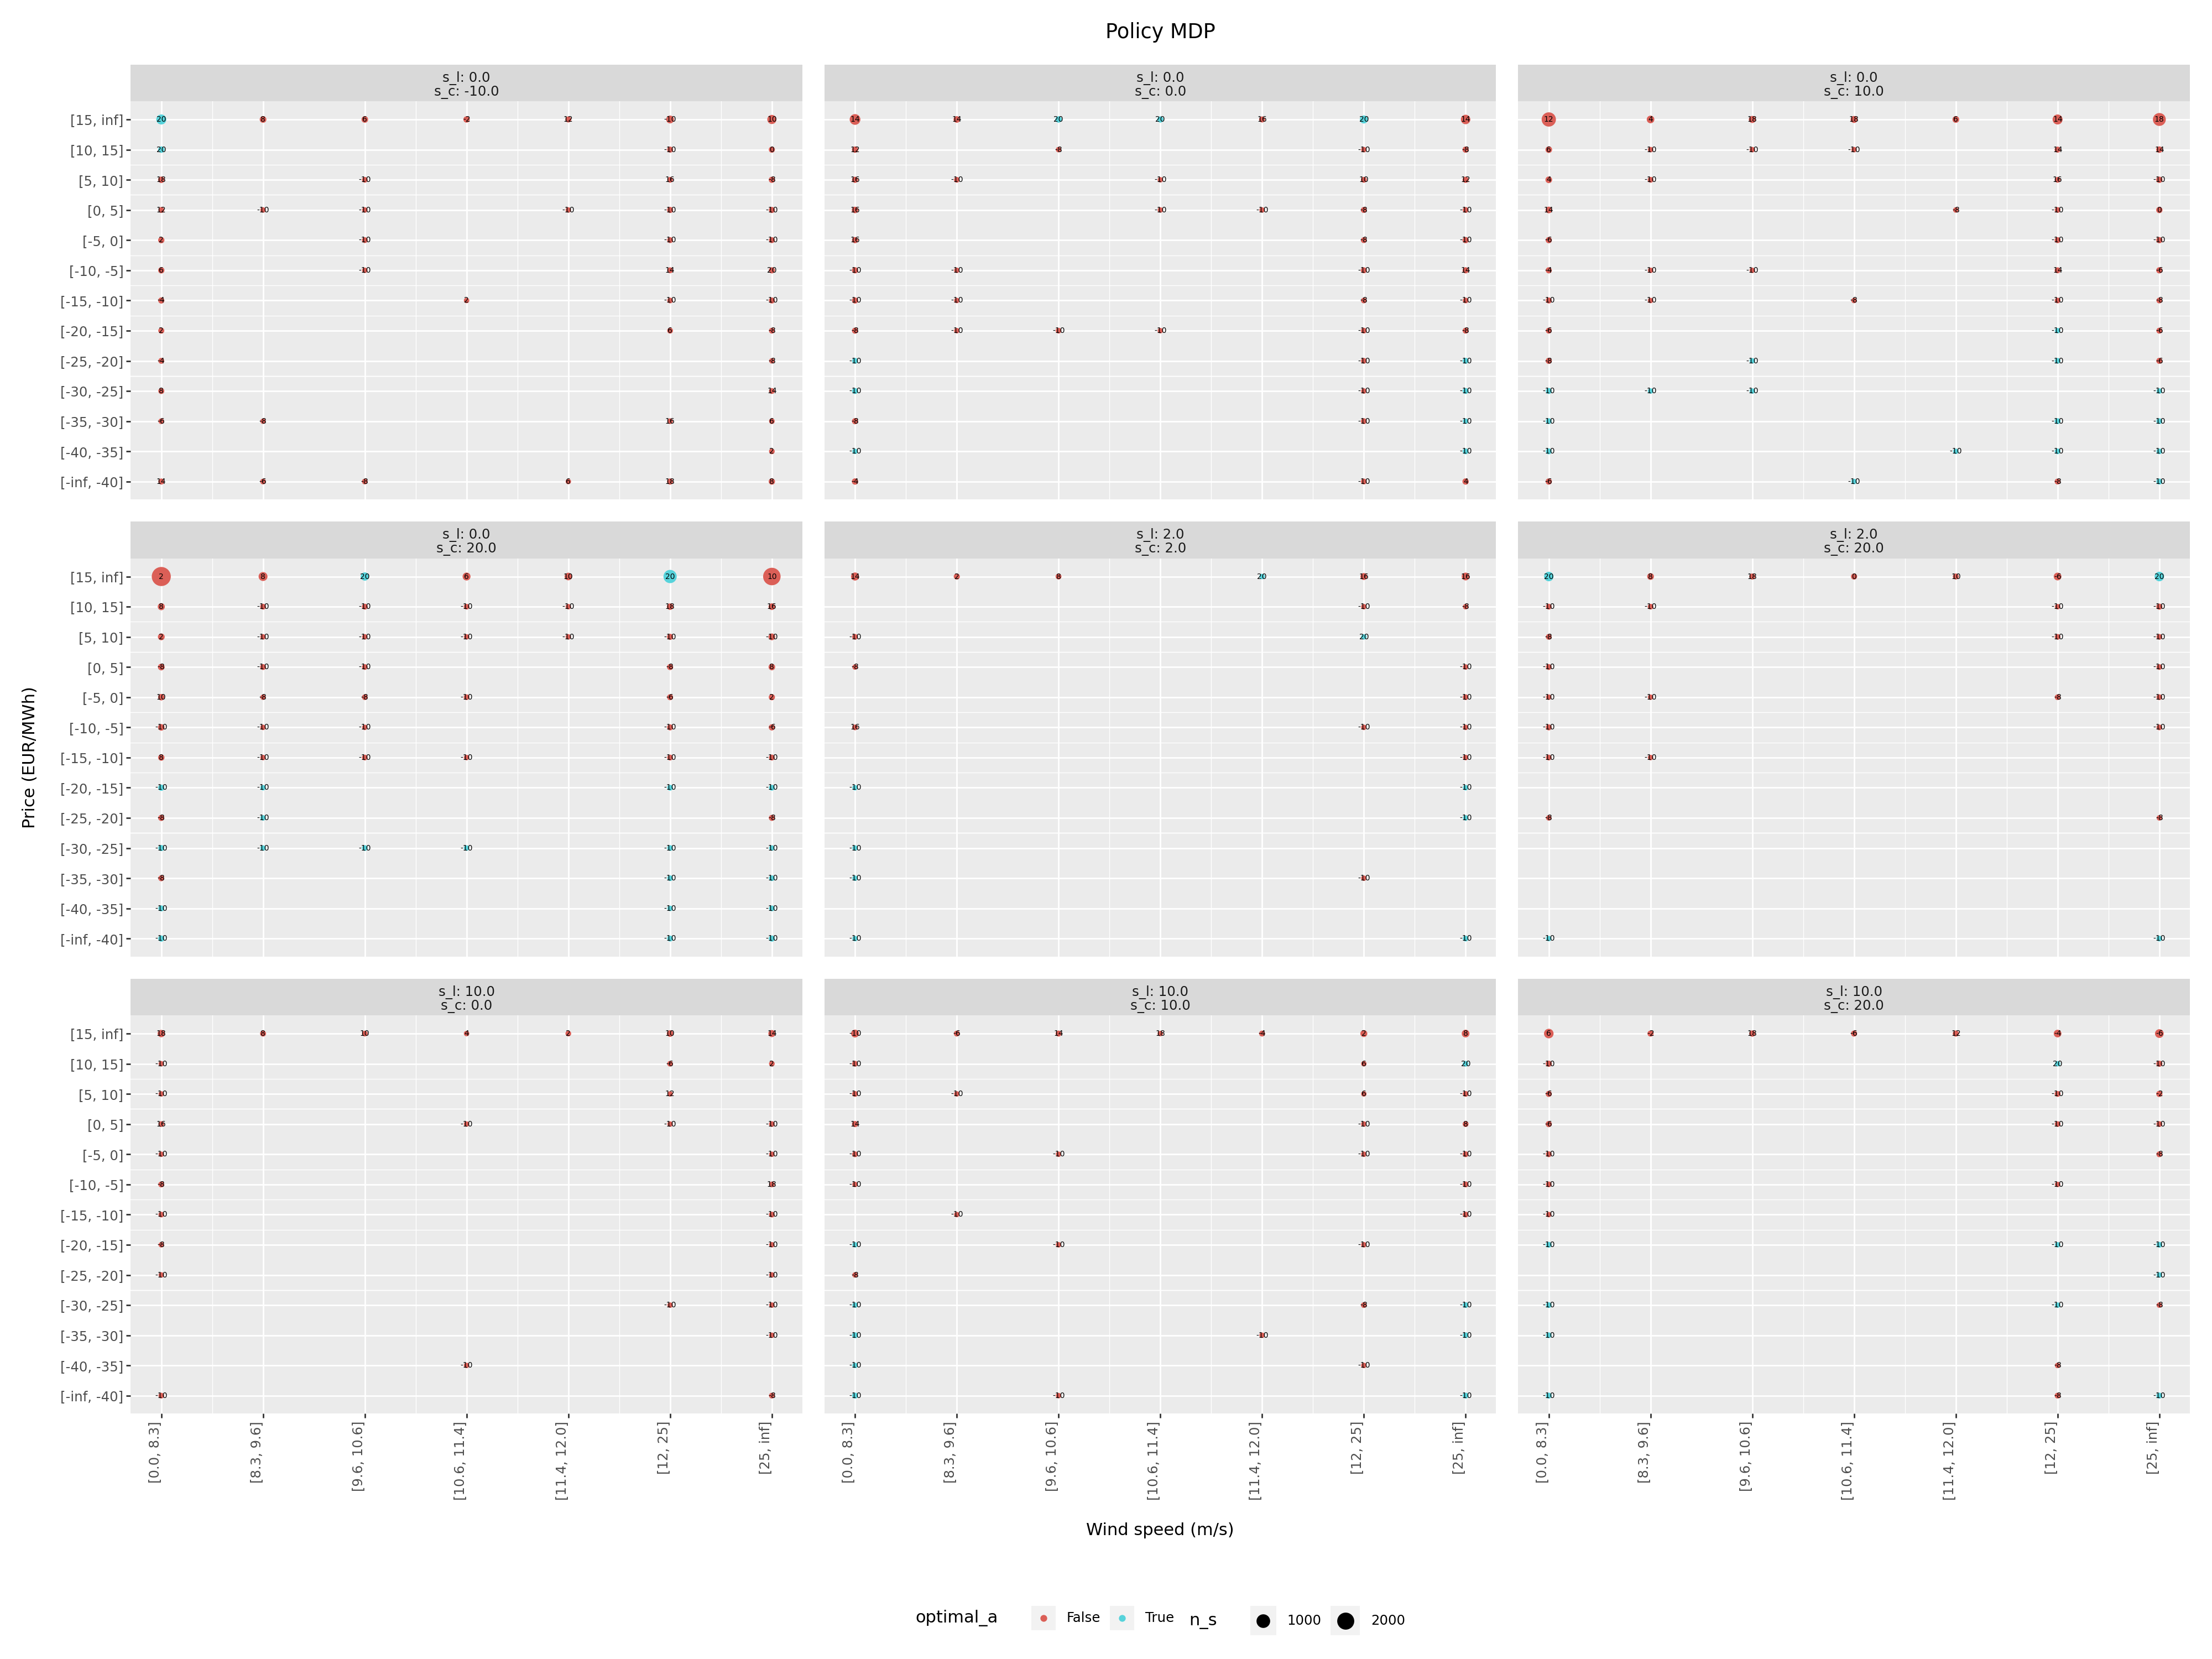

In [ ]:
def get_plot(dat = df_result):
    dat = (
        dat
            >> mask((X.s_l == 0) | (X.s_l == 2) | (X.s_l == 5) | (X.s_l == 10))
            >> mask((X.s_c == -10) | (X.s_c == -2) | (X.s_c == 0) | (X.s_c == 2) | (X.s_c == 10) | (X.s_c == 20))
            >> mask(X.steady_pr > 0)
    )
    dat['a_c'] = pd.Categorical(dat['a_c'])  # Convert 'a_c' to a categorical variable for discrete scaling
    pt = (
        ggplot(dat, aes("s_w_idx", "s_p_idx", label = "a_c", color="optimal_a", size = 'n_s'))
        + geom_point()
        + geom_text(size=5, color = "black")
        + facet_wrap("~ s_l + s_c", labeller="label_both")
        # + facet_grid(rows = "s_l", cols = "s_c", labeller="label_both")
        # + theme(legend_position='none')
        + labs(title = f"Policy MDP", x = "Wind speed (m/s)", y = "Price (EUR/MWh)")
        + theme(figure_size=(20,15), axis_text_x=element_text(rotation=90, hjust=1), legend_position="bottom")
        # + guides(color=guide_legend(nrow=2, byrow=True))
        # + guides(color=False)
        + scale_color_discrete()
        + scale_x_continuous(breaks=dat['s_w_idx'].unique(), labels=dat['s_w_str'].unique())
        + scale_y_continuous(breaks=dat['s_p_idx'].unique(), labels=dat['s_p_str'].unique())
    )
    pt.show()
get_plot()

## Q10

Comment on the plot.

In [ ]:
#@title Solution

display(Markdown("""
* Comment on the plot
	* Size of the circles are representing n_s = states visited. So the larger circles are the more frequently visited states during the sample iterations.
	* The red colouring shows when optimal_a is false and blue when true. Blue reflects when the action learned by Q-learning is an optimal action for that state. (The action learned by the Q-learning for this state matches the action in the MDP)
	* Areas where there is nothing, means that state has not been visited.

	We observe that there are some states that are visited a lot more often than
	others, especially the prices > 15, and wind levels that are very low or very
	high. This could be because the intervals are a lot larger in the edges,
	and therefore this is a more probable state to visit.
	There are also a lot of states which are not visited at all, which might also
	be a problem for the model.

	There are also a lot more red dots than blue dots, indiciating that we have
	not found the optimal states a lot of the time. Reducing epsilon might be
	a possible solution, which could better estimate the greedy strategy.
"""))


* Comment on the plot
	* Size of the circles are representing n_s = states visited. So the larger circles are the more frequently visited states during the sample iterations.
	* The red colouring shows when optimal_a is false and blue when true. Blue reflects when the action learned by Q-learning is an optimal action for that state. (The action learned by the Q-learning for this state matches the action in the MDP)
	* Areas where there is nothing, means that state has not been visited.

	We observe that there are some states that are visited a lot more often than
	others, especially the prices > 15, and wind levels that are very low or very
	high. This could be because the intervals are a lot larger in the edges,
	and therefore this is a more probable state to visit.
	There are also a lot of states which are not visited at all, which might also
	be a problem for the model.

	There are also a lot more red dots than blue dots, indiciating that we have
	not found the optimal states a lot of the time. Reducing epsilon might be
	a possible solution, which could better estimate the greedy strategy.


## Q11

Experiment with the Q-learning algorithm. Try to find a better approximation by choosing good initial q-values, epsilon and alpha (you may also try a decreasing step-size - see the documentation for the method).

Discuss your results.


In [ ]:
print("\nQ-learning warm-up & long training:")
env.reset_current_state()
env.reset_rng(seed=123)

total_iters = 5_000_000
initial_lr = 0.3         # high learning rate at the start
final_lr   = 0.01        # minimum learning rate later
warmup     = 100_000     # iterations using high lr before decay stage
chunk_size = 50_000      # train in chunks so we can update hyperparameters

iters_done = 0

while iters_done < total_iters:
    # learning rate schedule
    if iters_done < warmup:
        alpha = initial_lr
    else:
        # Smooth linear decay from 100k to 5M
        t = (iters_done - warmup) / (total_iters - warmup)
        alpha = initial_lr * (1 - t) + final_lr * t

    # Train this block WITHOUT RESETTING Q
    agent.gpi_off_policy_q_learning(
        env,
        max_el = chunk_size,
        reset = False,     # ← keep Q-values
        gamma = 0.5,
        eps   = 0.1,
        alpha = alpha
    )

    iters_done += chunk_size
    if iters_done % 500_000 == 0:
        print(f"Progress: {iters_done:,} iterations   α={alpha:.4f}")

# Evaluate
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"\nFinal Results:")
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")

In [ ]:
episodes = 500000
val_q = 500
val_eps = 0.5
val_alpha = 0.05
dec_alpha = True

env.reset_current_state()
env.reset_rng(seed=123)

agent.set_action_value(val_q)
agent.set_action_ctr_value(0)

agent.gpi_off_policy_q_learning(
    env,
    max_el=episodes,
    reset=False,
    gamma=0.5,
    eps=val_eps,
    alpha=val_alpha,
    decreasing_alpha=dec_alpha
)

df_result = get_result_df()

In [ ]:
#@title Solution

display(Markdown("""
The RMS was lowered down to 623 with nRMS of 0.10 or 10% error, This was done over 5.000.000 iterations with a dropof in alpha where it started
high and eventually lowered. We can also see that we visit more states then in the previous 50.000 iteration solution (Q9) (NOTE that this plot
is from the 1.000.000 iteration solution not the best performing model)

By setting the q-values we also see that we through less iterations are able to
get closer to the optimal. This could furthermore be optimized by initializing
the q-values to the optimal MDP values.

Exploration could be further optimized by running for only 50.000 iterations and then manually changing the starting state values, in order to Force
exploration in that area. This would ensure that states that have a low propability
of happinging are still visited.

The risk of lowering the epsilon too fast, is that we reduce it before we have
explored enough, which will result in sub-optimal choices in the future iterations.
"""))


The RMS was lowered down to 623 with nRMS of 0.10 or 10% error, This was done over 5.000.000 iterations with a dropof in alpha where it started
high and eventually lowered. We can also see that we visit more states then in the previous 50.000 iteration solution (Q9) (NOTE that this plot
is from the 1.000.000 iteration solution not the best performing model)

By setting the q-values we also see that we through less iterations are able to
get closer to the optimal. This could furthermore be optimized by initializing
the q-values to the optimal MDP values. 

Exploration could be further optimized by running for only 50.000 iterations and then manually changing the starting state values, in order to Force
exploration in that area. This would ensure that states that have a low propability
of happinging are still visited.

The risk of lowering the epsilon too fast, is that we reduce it before we have 
explored enough, which will result in sub-optimal choices in the future iterations.


In [ ]:
print("\nQ-learning warm-up & long training:")
env.reset_current_state()
env.reset_rng(seed=123)

total_iters = 5000000
initial_lr = 0.3         # high learning rate at the start
final_lr   = 0.01        # minimum learning rate later
warmup     = 100000     # iterations using high lr before decay stage
chunk_size = 50000      # train in chunks so we can update hyperparameters

iters_done = 0

while iters_done < total_iters:
    if iters_done < warmup:
        alpha = initial_lr
    else:
        t = (iters_done - warmup) / (total_iters - warmup)
        alpha = initial_lr * (1 - t) + final_lr * t

    agent.gpi_off_policy_q_learning(
        env,
        max_el = chunk_size,
        reset = False,
        gamma = 0.5,
        eps   = 0.1,
        alpha = alpha
    )

    iters_done += chunk_size
    if iters_done % 500000 == 0:
        print(f"Progress: {iters_done:,} iterations   α={alpha:.4f}")

# Evaluate
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"\nFinal Results:")
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")



Q-learning warm-up & long training:
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 500,000 iterations   α=0.2793
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 1,000,000 iterations   α=0.2497
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 1,500,000 iterations   α=0.2201
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning

NameError: name 'get_result_df' is not defined

*Note issues with get_result_df due to not loading previous cells properly the code below should rectify this issue

In [ ]:
# Evaluate
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"\nFinal Results:")
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")


Final Results:
Unweighted RMS = 623.798787 | nRMS = 0.100913


In [ ]:
print("\nQ-learning:")
env.reset_current_state()
env.reset_rng(seed=123)
agent.gpi_off_policy_q_learning(env, max_el = 100000, reset = False, gamma = 0.5, eps = 0, alpha = 0.1)
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")



Q-learning:
GPI/Q-learning finished.
Unweighted RMS = 638.275860 | nRMS = 0.103255


Trying a greedy strategy showed that the nRMS increased a bit, meaning that we might not have found the optimal policy, we still need more exploration in order to find the optimal policy. Maybe the alpha (called learning rate in the script) should be decreased over a longer time period (meaning the iterations also should be increased).

Test V3

In [ ]:
print("\nQ-learning warm-up & long training:")
env.reset_current_state()
env.reset_rng(seed=123)

total_iters = 1000000
initial_lr = 0.3         # high learning rate at the start
final_lr   = 0.01        # minimum learning rate later
warmup     = 100000     # iterations using high lr before decay stage
chunk_size = 100000      # Increased chunk size so we go over the space more often

iters_done = 0

while iters_done < total_iters:
    if iters_done < warmup:
        alpha = initial_lr
    else:
        t = (iters_done - warmup) / (total_iters - warmup)
        alpha = initial_lr * (1 - t) + final_lr * t

    agent.gpi_off_policy_q_learning(
        env,
        max_el = chunk_size,
        reset = False,
        gamma = 0.5,
        eps   = 0.1,
        alpha = alpha
    )

    iters_done += chunk_size
    if iters_done % 500000 == 0:
        print(f"Progress: {iters_done:,} iterations   α={alpha:.4f}")

# Evaluate
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print(f"\nFinal Results:")
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")



Q-learning warm-up & long training:
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 500,000 iterations   α=0.2033
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 1,000,000 iterations   α=0.0422

Final Results:
Unweighted RMS = 699.929119 | nRMS = 0.113228


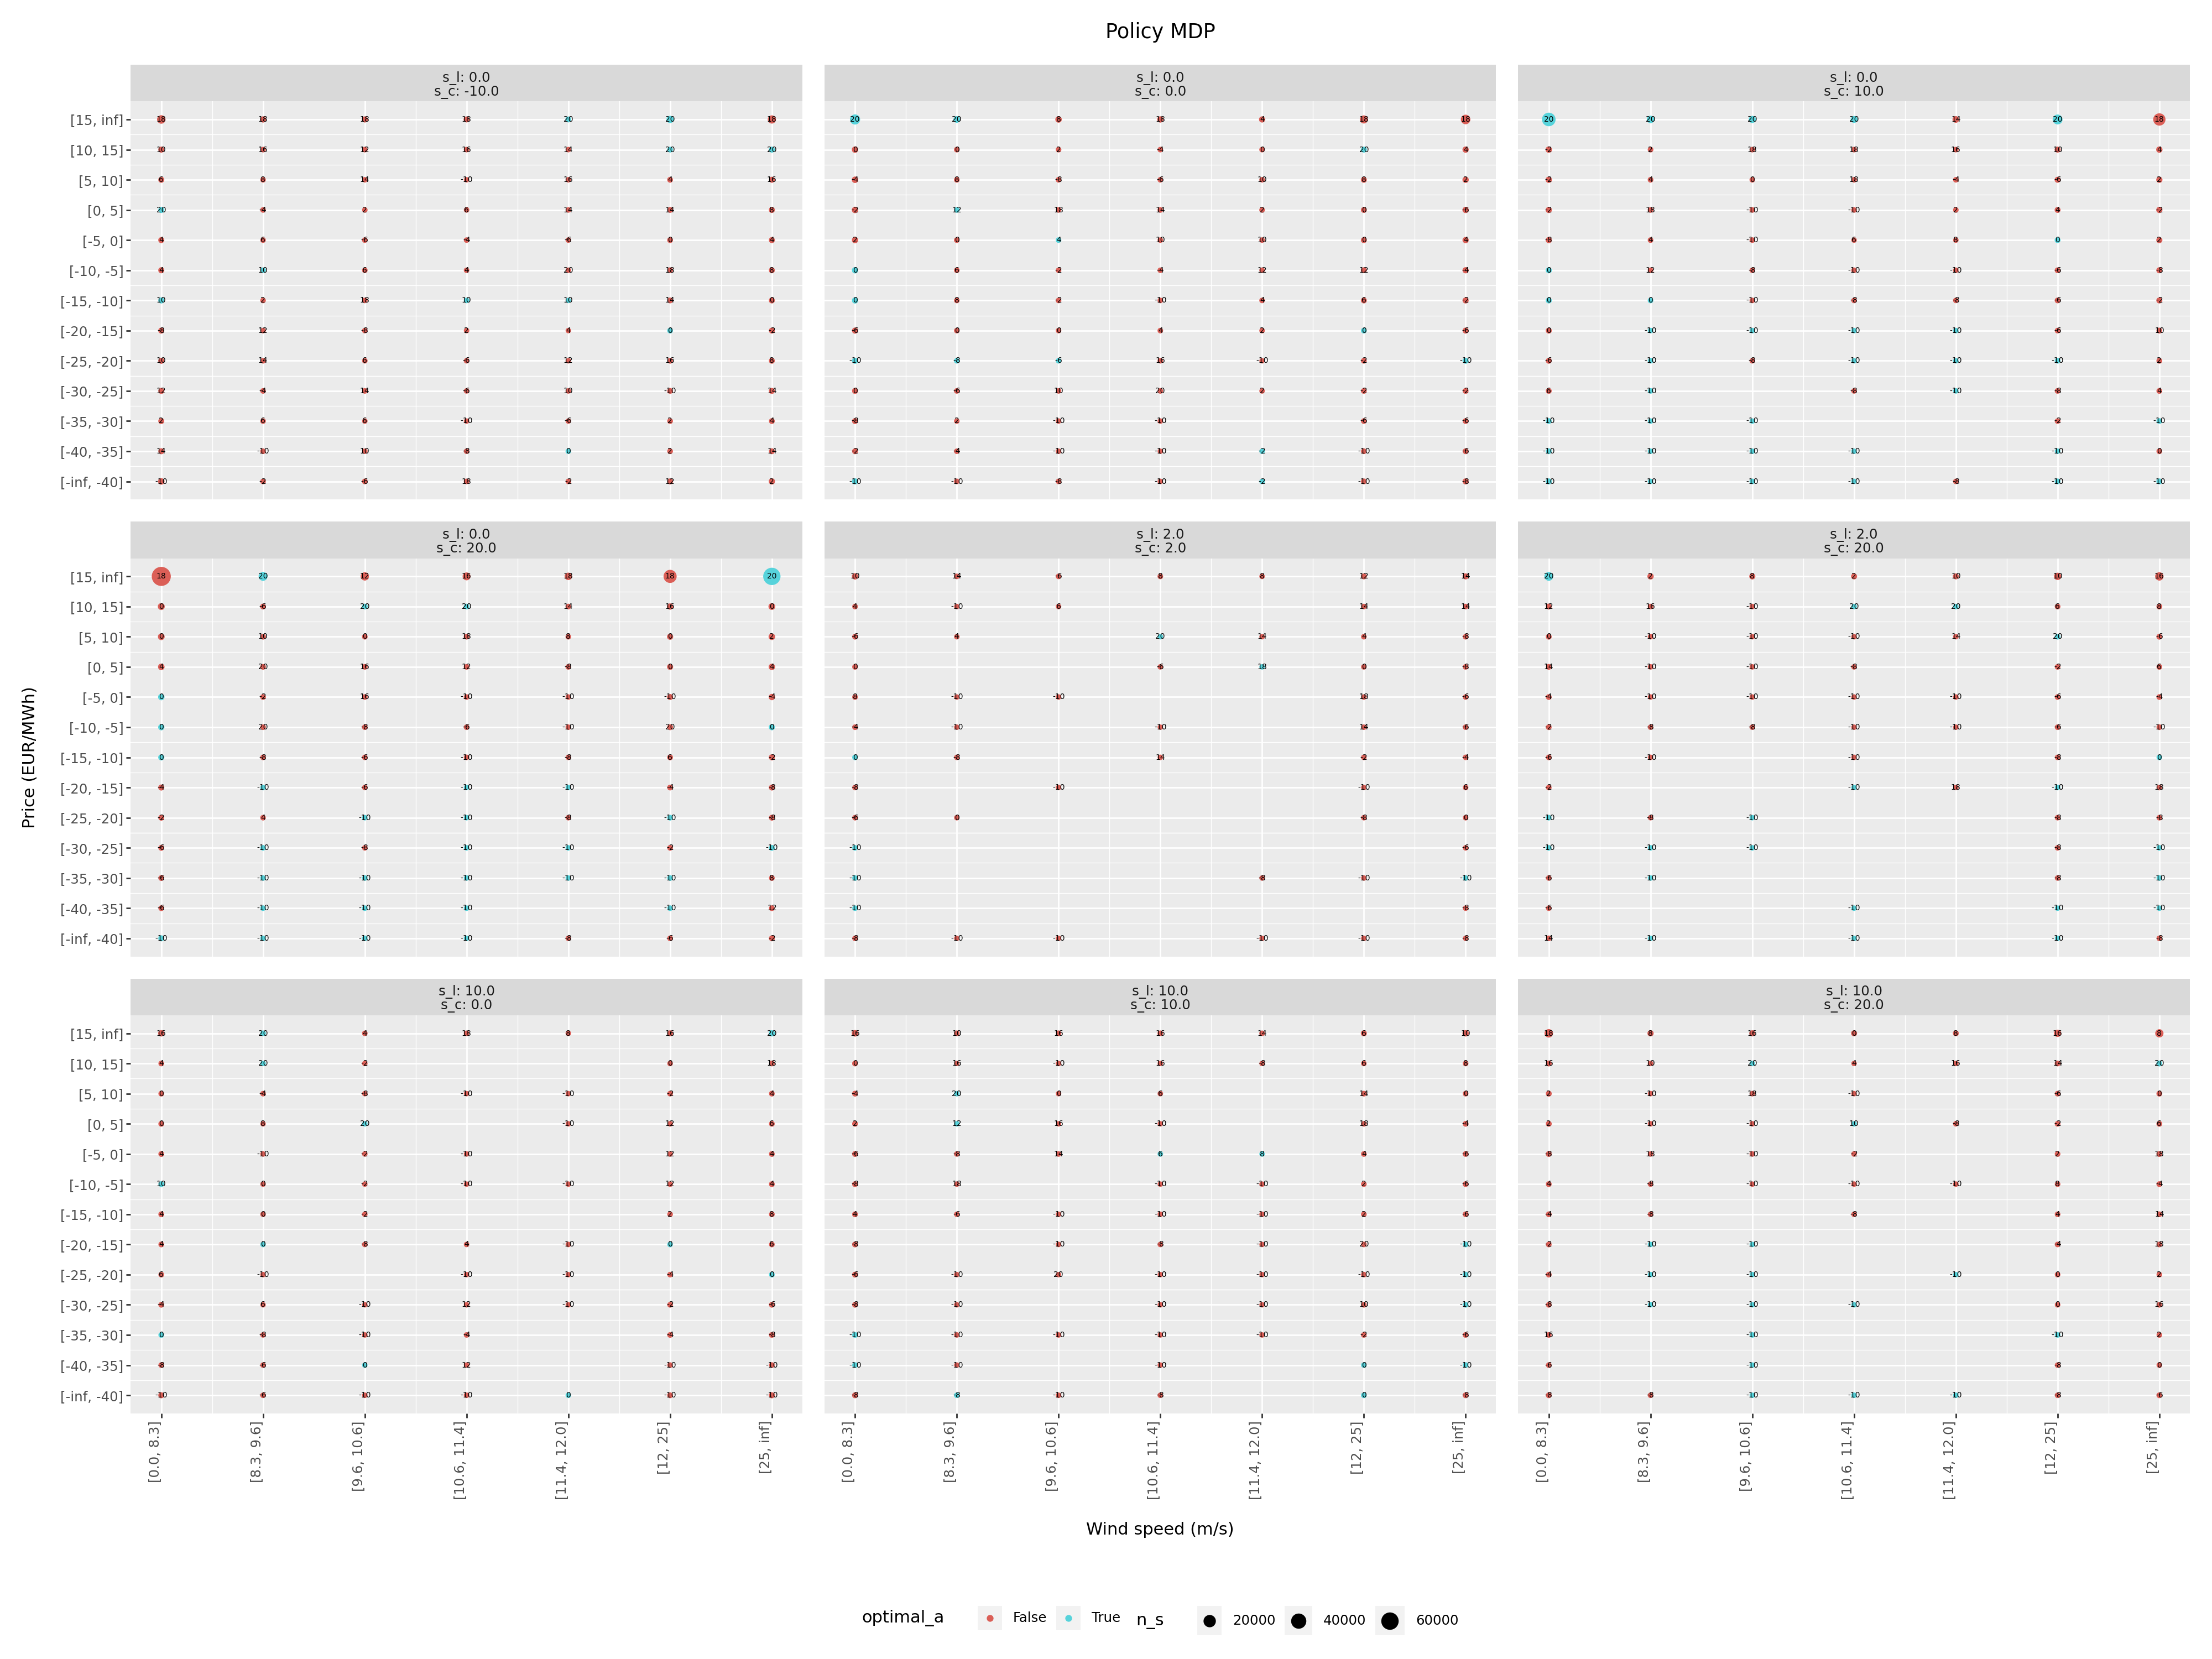

In [ ]:
def get_plot(dat = df_result):
    dat = (
        dat
            >> mask((X.s_l == 0) | (X.s_l == 2) | (X.s_l == 5) | (X.s_l == 10))
            >> mask((X.s_c == -10) | (X.s_c == -2) | (X.s_c == 0) | (X.s_c == 2) | (X.s_c == 10) | (X.s_c == 20))
            >> mask(X.steady_pr > 0)
    )
    dat['a_c'] = pd.Categorical(dat['a_c'])  # Convert 'a_c' to a categorical variable for discrete scaling
    pt = (
        ggplot(dat, aes("s_w_idx", "s_p_idx", label = "a_c", color="optimal_a", size = 'n_s'))
        + geom_point()
        + geom_text(size=5, color = "black")
        + facet_wrap("~ s_l + s_c", labeller="label_both")
        # + facet_grid(rows = "s_l", cols = "s_c", labeller="label_both")
        # + theme(legend_position='none')
        + labs(title = f"Policy MDP", x = "Wind speed (m/s)", y = "Price (EUR/MWh)")
        + theme(figure_size=(20,15), axis_text_x=element_text(rotation=90, hjust=1), legend_position="bottom")
        # + guides(color=guide_legend(nrow=2, byrow=True))
        # + guides(color=False)
        + scale_color_discrete()
        + scale_x_continuous(breaks=dat['s_w_idx'].unique(), labels=dat['s_w_str'].unique())
        + scale_y_continuous(breaks=dat['s_p_idx'].unique(), labels=dat['s_p_str'].unique())
    )
    pt.show()
get_plot()

Even with 1 million iterations there isnt some states which we dont visit (as can be seen with the missing dot)

Test V4

- The goal of this test was to both start with an high alpha and high epsilon in order to improve a lot in the start while also exploring a lot. Both these metrics where decreased linearly over 5.000.000 iterations.

In [ ]:
#Q-learning with decaying epsilon and decaying alpha
print("\nQ-learning warm-up & long training:")
env.reset_current_state()
env.reset_rng(seed=123)

total_iters = 5000000   # Very high iterations
initial_lr = 0.3         # high LR early
final_lr   = 0.01        # lower LR later
warmup     = 100000     # iterations before lr decay starts
chunk_size = 100000

# ε-decay setup
eps_start = 0.4          # high exploration early
eps_end   = 0.01         # retain small exploration late
eps_decay_iters = total_iters  # decay across full training

iters_done = 0

while iters_done < total_iters:

    # ---- Learning rate schedule ----
    if iters_done < warmup:
        alpha = initial_lr
    else:
        t_lr = (iters_done - warmup) / (total_iters - warmup)
        alpha = initial_lr * (1 - t_lr) + final_lr * t_lr

    # ---- Epsilon schedule (linear decay) ----
    t_eps = iters_done / eps_decay_iters
    eps = eps_start * (1 - t_eps) + eps_end * t_eps

    # Run Q-learning segment
    agent.gpi_off_policy_q_learning(
        env,
        max_el = chunk_size,
        reset = False,
        gamma = 0.5,
        eps   = eps,
        alpha = alpha
    )

    iters_done += chunk_size

    if iters_done % 500000 == 0:
        print(f"Progress: {iters_done:,} iterations | α={alpha:.4f}  ε={eps:.4f}")

# Evaluate
df_result = get_result_df()
rms, nrms = get_rms(df_result, weighted=False)
print("\nFinal Results:")
print(f"Unweighted RMS = {rms:.6f} | nRMS = {nrms:.6f}")



Q-learning warm-up & long training:
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 500,000 iterations | α=0.2822  ε=0.3688
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 1,000,000 iterations | α=0.2527  ε=0.3298
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 1,500,000 iterations | α=0.2231  ε=0.2908
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 2,000,000 iterations | α=0.1935  ε=0.2518
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
Progress: 2,500,000 iterations | α=0.1639  ε=0.2128
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q-learning finished.
GPI/Q

In [ ]:
df_result

,state,action_x,q,n,n_s,s_l,s_c,s_w,s_p,a_b,...,reward,s_w_idx,s_w_str,s_p_idx,s_p_str,s_idx,steady_pr,optimal_a,states,visits
0,"{'s_l': 0, 's_c': -10, 's_w': 10.1, 's_p': -12.5}","{'a_b': -10, 'a_w': 0, 'a_c': -6}",119.613219,17,24,0.0,-10.0,10.10,-12.5,-10,...,125.0,2,"[9.6, 10.6]",6,"[-15, -10]",32,2.127413e-05,False,8248,5000005
1,"{'s_l': 0, 's_c': -10, 's_w': 10.1, 's_p': -17.5}","{'a_b': -10, 'a_w': 0, 'a_c': 10}",185.934514,22,25,0.0,-10.0,10.10,-17.5,-10,...,175.0,2,"[9.6, 10.6]",5,"[-20, -15]",31,2.178409e-05,False,8248,5000005
2,"{'s_l': 0, 's_c': -10, 's_w': 10.1, 's_p': -2.5}","{'a_b': -10, 'a_w': 0, 'a_c': 0}",165.888829,24,28,0.0,-10.0,10.10,-2.5,-10,...,25.0,2,"[9.6, 10.6]",8,"[-5, 0]",34,1.709500e-05,False,8248,5000005
3,"{'s_l': 0, 's_c': -10, 's_w': 10.1, 's_p': -22.5}","{'a_b': -10, 'a_w': 0, 'a_c': -4}",235.783493,22,24,0.0,-10.0,10.10,-22.5,-10,...,225.0,2,"[9.6, 10.6]",4,"[-25, -20]",30,2.109633e-05,False,8248,5000005
4,"{'s_l': 0, 's_c': -10, 's_w': 10.1, 's_p': -27.5}","{'a_b': -10, 'a_w': 0, 'a_c': -4}",283.086144,20,22,0.0,-10.0,10.10,-27.5,-10,...,275.0,2,"[9.6, 10.6]",3,"[-30, -25]",29,1.934794e-05,False,8248,5000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,"{'s_l': 8, 's_c': 8, 's_w': 8.95, 's_p': -7.5}","{'a_b': 6, 'a_w': 2, 'a_c': -6}",59.567558,10,12,8.0,8.0,8.95,-7.5,6,...,-60.0,1,"[8.3, 9.6]",7,"[-10, -5]",6663,2.793131e-07,False,8248,5000005
8244,"{'s_l': 8, 's_c': 8, 's_w': 8.95, 's_p': 12.5}","{'a_b': 6, 'a_w': 2, 'a_c': 12}",444.500328,8,9,8.0,8.0,8.95,12.5,6,...,100.0,1,"[8.3, 9.6]",11,"[10, 15]",6667,2.319532e-07,False,8248,5000005
8245,"{'s_l': 8, 's_c': 8, 's_w': 8.95, 's_p': 16}","{'a_b': 6, 'a_w': 2, 'a_c': 14}",813.567194,6,83,8.0,8.0,8.95,16.0,6,...,1100.0,1,"[8.3, 9.6]",12,"[15, inf]",6668,6.178695e-07,False,8248,5000005
8246,"{'s_l': 8, 's_c': 8, 's_w': 8.95, 's_p': 2.5}","{'a_b': 6, 'a_w': 2, 'a_c': 2}",241.541431,10,10,8.0,8.0,8.95,2.5,6,...,20.0,1,"[8.3, 9.6]",9,"[0, 5]",6665,2.879276e-07,False,8248,5000005


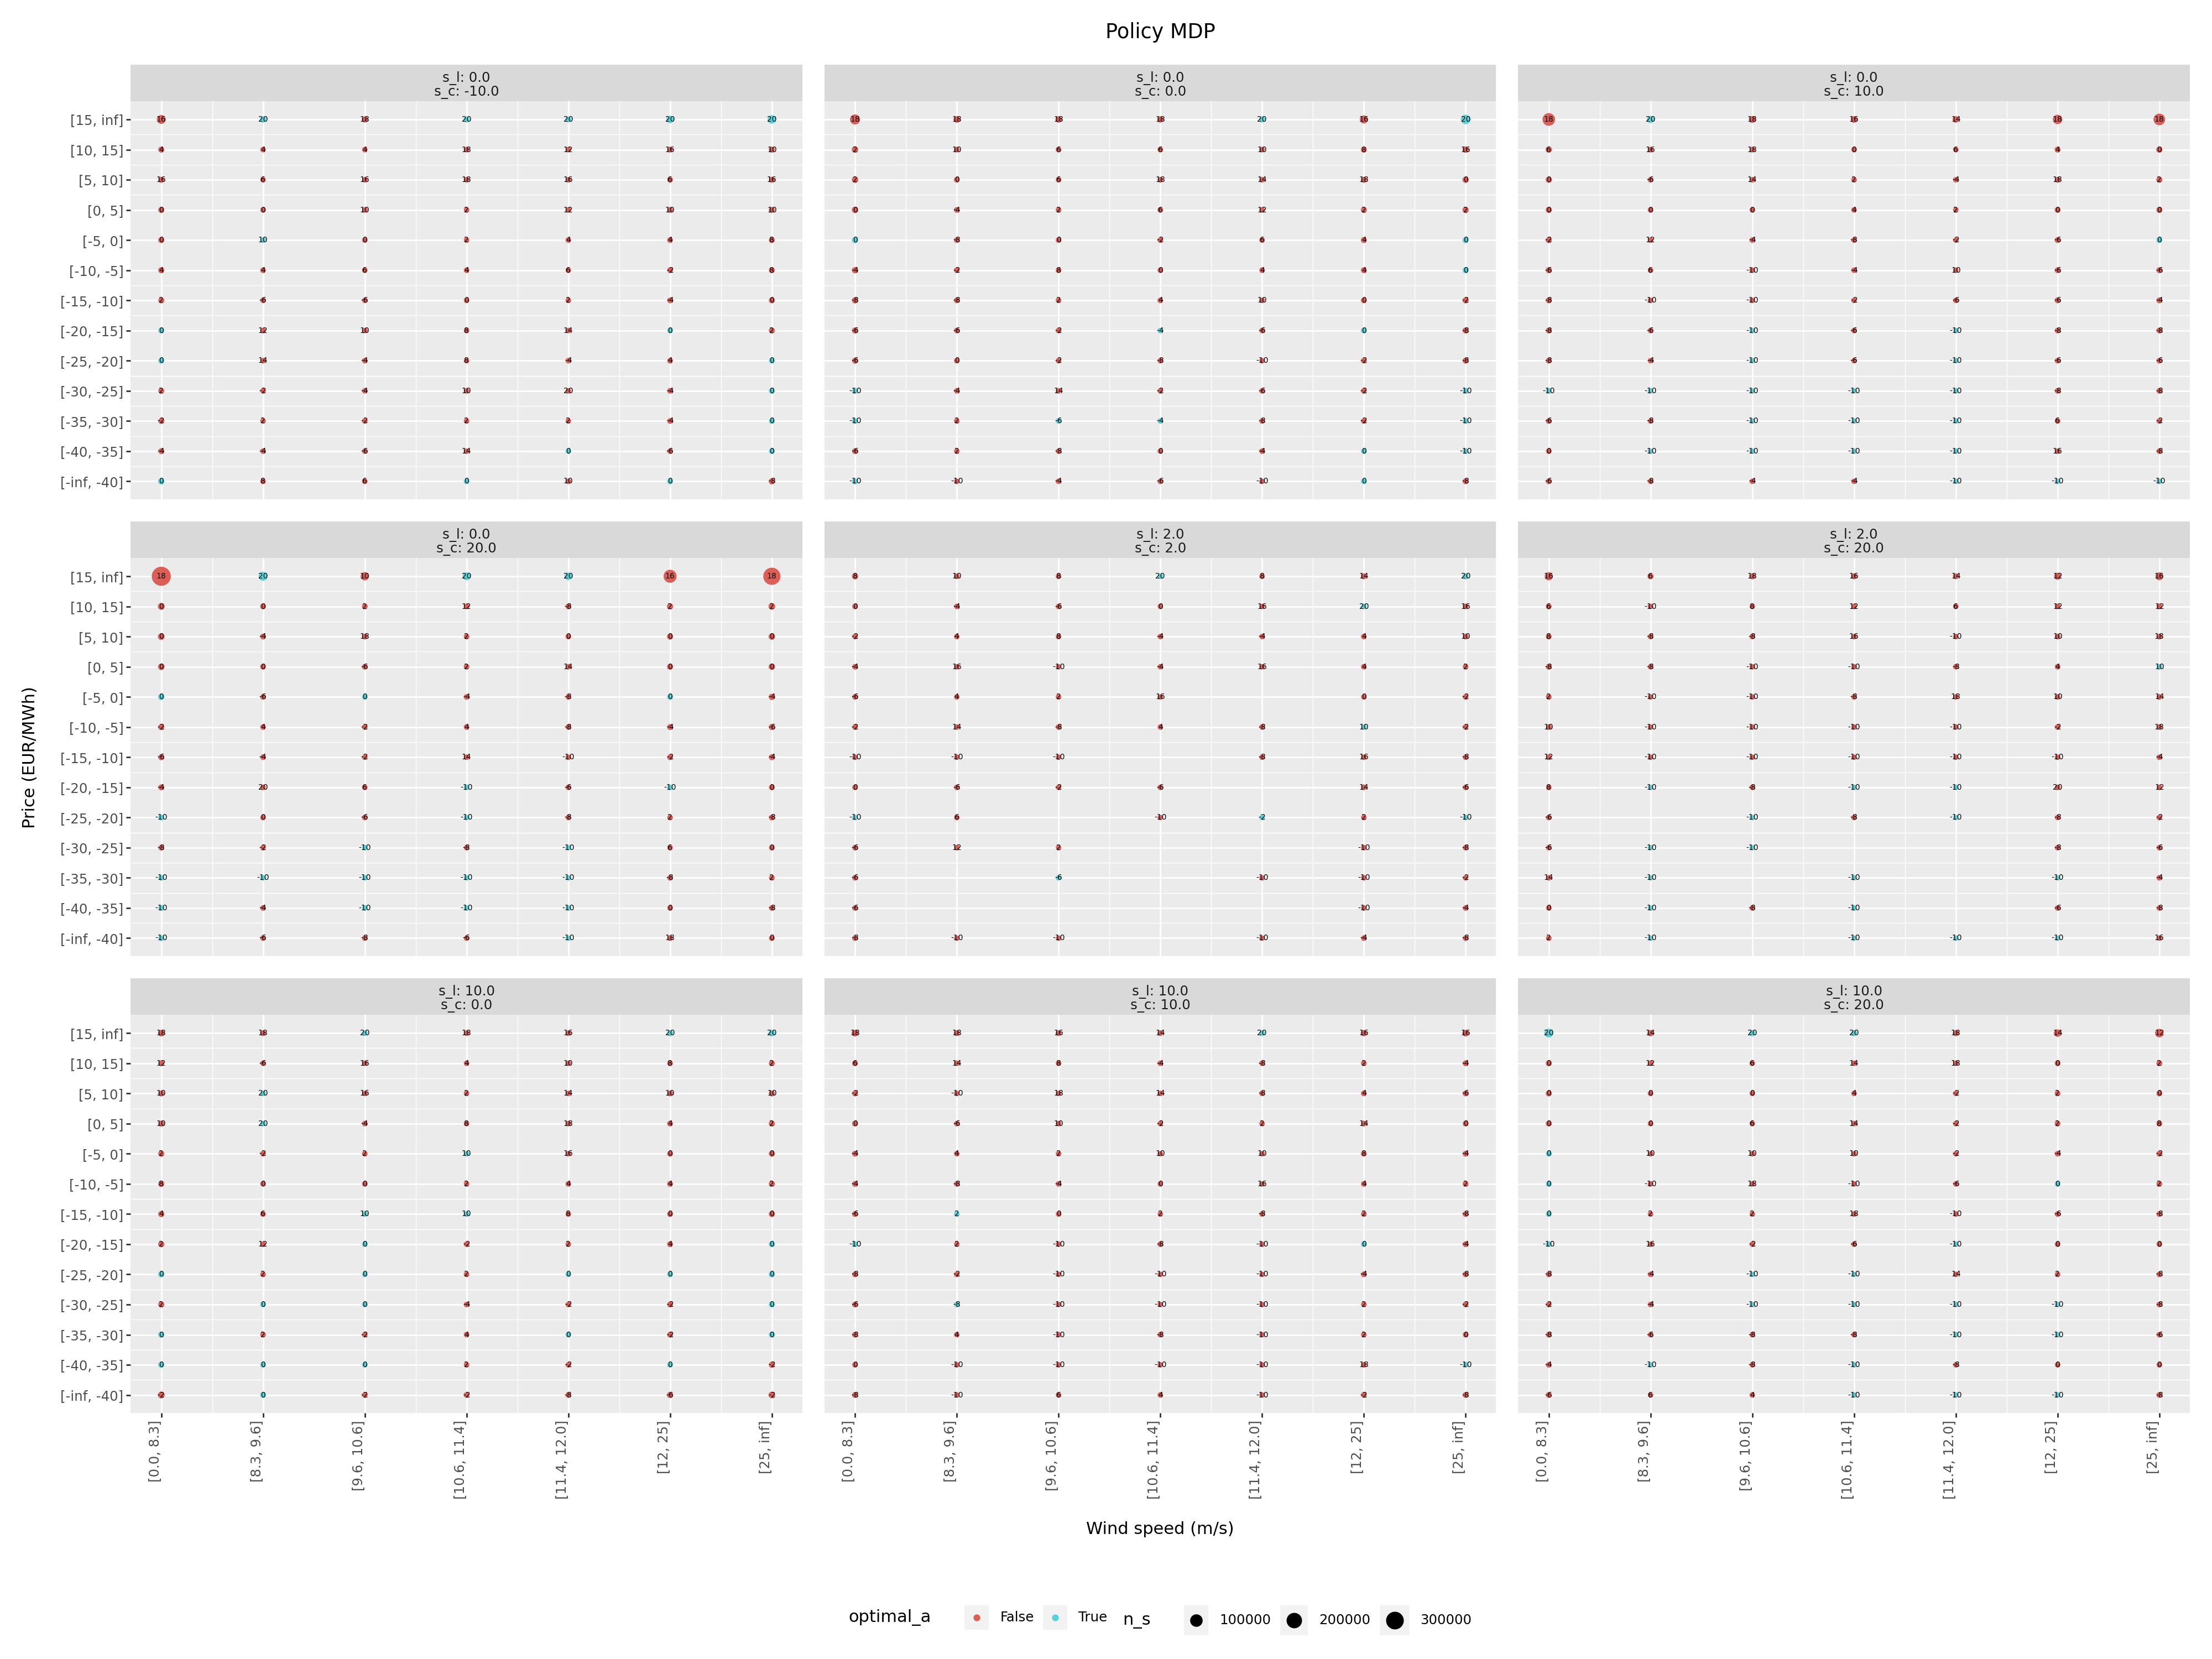

In [ ]:
def get_plot(dat = df_result):
    dat = (
        dat
            >> mask((X.s_l == 0) | (X.s_l == 2) | (X.s_l == 5) | (X.s_l == 10))
            >> mask((X.s_c == -10) | (X.s_c == -2) | (X.s_c == 0) | (X.s_c == 2) | (X.s_c == 10) | (X.s_c == 20))
            >> mask(X.steady_pr > 0)
    )
    dat['a_c'] = pd.Categorical(dat['a_c'])  # Convert 'a_c' to a categorical variable for discrete scaling
    pt = (
        ggplot(dat, aes("s_w_idx", "s_p_idx", label = "a_c", color="optimal_a", size = 'n_s'))
        + geom_point()
        + geom_text(size=5, color = "black")
        + facet_wrap("~ s_l + s_c", labeller="label_both")
        # + facet_grid(rows = "s_l", cols = "s_c", labeller="label_both")
        # + theme(legend_position='none')
        + labs(title = f"Policy MDP", x = "Wind speed (m/s)", y = "Price (EUR/MWh)")
        + theme(figure_size=(20,15), axis_text_x=element_text(rotation=90, hjust=1), legend_position="bottom")
        # + guides(color=guide_legend(nrow=2, byrow=True))
        # + guides(color=False)
        + scale_color_discrete()
        + scale_x_continuous(breaks=dat['s_w_idx'].unique(), labels=dat['s_w_str'].unique())
        + scale_y_continuous(breaks=dat['s_p_idx'].unique(), labels=dat['s_p_str'].unique())
    )
    pt.show()
get_plot()

A lot of states was visited as we can see that we almost visited them all. However the RMS nor the nRMS saw any improvement from the previous tests.